### PARTIE 2

In [1]:
#version de sckit-learn
import sklearn
print(sklearn.__version__)

0.23.1


In [2]:
#version de pandas
import pandas as pd
print(pd.__version__)

1.3.5


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
%pylab inline

plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

Populating the interactive namespace from numpy and matplotlib


## 1- Importation des données

In [5]:
# Enregistrement du dataframe final
from pathlib import Path
import pickle as pk 

# Lire un fichier
def read_pickle(destination, filename):
    if not isinstance(destination, Path):
        destination = Path(destination)
        
    fichier  = destination/filename
    with open(fichier, 'rb') as f:
        df = pk.load(f)
    return df 

# Save un dataframe final
def dump_pickle( df, destination, filename):
    dossier = Path(destination)
    fichier  = dossier/filename
    with open(fichier, 'wb') as f:
        pk.dump(df, f)

In [6]:
z = ZipFile("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 504)

In [7]:
TARGET = pd.read_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

### 2- Données d'entraînement et test

Commençons par diviser les données en un ensemble pour entraîner les algorithmes et un ensemble de test pour évaluer la capacité du modèle à généraliser sur de nouvelles données (performance du modèle construit)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [9]:
#Vérification de la dimension dans chaque dataSetù
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 504), (92254, 504), (215257, 1), (92254, 1))

### 3- Résolution du problème de déséquilibre de classe

Il existe plusieurs technique pour résoudre le problème de déséquilibre de classe dans les données. Le rééchantillonnage des données est l'une des techniques les plus utilisées. Les méthodes de rééchantillonnage souvent utilisée sont:

* de sous-échantillonement de la classe majoritaire (**Random Under Sampling** ou RUS): cette méthode consiste à tirer au hasard des observations de cas de non-défaut pour correspondre au nombre d'observations de cas de défaut de paiement;

* sur-échantillonement de la classe minoritaire (**Random Over Sampling** ou ROS): cette méthode consiste à éffectuer des tirages aléatoires d'observations de cas défaut et dupliquer ces observations afin de correspondre au nombre de cas non-défaut

Ces deux méthodes conduisent à un équilibre parfait des cas de défaut et non-défaut de paiement mais présentent quand même des inconvénients. Avec le sous-échantillonnage, vous supprimez beaucoup d'informations. Dans la plupart des cas, jeter des données n'est pas souhaitable en apprentissage automatique. Alors le sur-échantillonnage, vous créez beaucoup de doublons d'informations ce qui peut créer des biais importants au niveau de l'entraîenement des algorithmes.

* Technique de suréchantillonnage des minorités synthétiques (Synthetic Minority Oversampling Technique ou **SMOTE** en anglais): c'est une téchnique sophistiquée qui ne se contente pas de juste dupliquer des cas de défaut mais utilise les caractéritiques des plus proches voisins des cas de défaut de paiement pour créer de nouveaux cas de défaut synthétiques. Cette méthode bien qu'utilisant des algorithmes hyper-sophistiqués présente le risque que les voisins les plus proches des cas de défaut ne soient pas en réalité des cas de défaut ce qui peut entraîner des erreurs de modélisation.

#### Oversampling Data Using SMOTE

In [10]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [11]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

Wall time: 5min 14s


In [12]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


## <span style="color:#006600"> 4-Modélisation </span>

### <span style="color:#39ac39"> 4-1 Choix de la métrique d'évaluation de performation du modèle</span>

Quelle métrique choisir pour évaluer la performance des modèles ?

vous devez préalablement comprendre ce qu'on appelle matrice de confusion.

La matrice de confusion est une matrice carrée qui apporte le nombre de vrais positifs (True Positive ou TP), vrais négatifs (True Nagtives ou TN), faux positifs (False Postives ou FP) et faux négatives (False Negatives ou FN).

Dans notre cas, la classe positive est 1: le client est en defaut de paienment et la classe négative est 0; le client n'est pas en défaut de paiement.

* **TP** : le client est en défaut de paiement et le modèle prédit qu'il est en défaut de paiement;

* **TN** : le client n'est pas en défaut de paiement et le modèle prédit qu'il n'est pas en défaut de paiement;

Les 2 cas ci-dessus (TP et TN) sont les bons cas. Mais FP et FN sont les mauvais cas:

* **FP** : le client n'est pas en defaut de paiement mais le modèle prédit qu'il est en défaut de paiement

* **FN** : le client est en défaut de paiement mais le modèle prédit qu'il n'est pas en défaut de paiement

A partir de la matrice de confusion, vous pouvez calculer certiaine métriques pour évaluer la performance du modèle.

* La **précision** de la classification (**Accuracy** en anglais) est le pourcentage d'instance correctement classifiées, c'est-à-dire la somme du nombre de vrais négatifs et de vrais positifs divisée par le nombre total des observations. Elle se calucle donc par la formule ci-dessous.

* La **sensibilité** du modèle (**Sensitivity** en anglais) se calcule par la formule:

Dans le cas présent, la sensibilité se traduit par le pourcentage de clients e défaut de paiement (classe positive) qui ont été calssifié comme tel par le modèle. Une sensibilité élevée est meilleure.

* La **spécificité** du modèle (**Specificity** en anglais) se calcule par la formule:

Ici, la spécificité est le pourcentage de clients qui ne sont pas en défauts de paiement (classe négative) et qui ont été classififié comme tel par le modèle.
Une spécificité élevée est mailleure. Mais if faudra un compromis entre la sensibilité du modèle et la spécificté car l'amélioration de la sensibilité diminue la spécificité et l'amélioration de la spécificité dimunie la sensibilité.

Il faut faire attention à la précision globale. Une forte précision globale ne signifie pas forcement que le modèle est performent. Le choix de la métrique pour quantifier la performance du modèle doit se faire en fonction du contexte de l'étude, c'est-à-dire de la problèmatique qu'on veut résoudre.

### <span style="color:#39ac39"> 4-2 Baseline model - Logistic Regression</span>

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [13]:
### 4-2-1 Sur des données déséquilibr

In [14]:
#Import de l' algorithme
from sklearn.linear_model import LogisticRegression

In [15]:
# Instanciation de l'algorithme
log_modeling = LogisticRegression(C = 0.0001, max_iter=100)

In [16]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling.fit(X_train, y_train)

LogisticRegression(C=0.0001)

In [17]:
# Prédiction sur les données de test
preds_log = log_modeling.predict_proba(X_test)
preds_log

array([[0.88212609, 0.11787391],
       [0.9333145 , 0.0666855 ],
       [0.89721241, 0.10278759],
       ...,
       [0.92012633, 0.07987367],
       [0.94891959, 0.05108041],
       [0.94035031, 0.05964969]])

**preds_log** donne la probabilité de défaut de paiement de chaque client de l'ensemble des données de test. Pour identifier les mauvais empruteurs des bons, il faudra définir une valeur seuil. Par exemple, on peut dire que si la probabilité prédite du client est inférieur à 0.5 alors il n'est pas en défaut de paiement et dans le cas contraire, c'est-à-dire pour une probabilité supérieure à 0.5, le client est en défaut de paiement.

Une autre façon de définir le seuil est de considérer la moyenne de la variable cible, c'est-à dire la proportion de la classe 1

In [18]:
# Définition d'un seuil
from sklearn import metrics
cost_function = []
seuil = 0.5

# Conversion des probabilité en résultat
y_scores = preds_log[:, 1]

# Score > seuil de solvabilité : retourne 1 sinon 0
preds_status = (preds_log[:, 1] > seuil)
preds_status = np.array(preds_status > 0) * 1

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_test, preds_status)
print("-----Métrice de confusion---")
print(conf_mat)

#Conposants de la matrice de confusion
TP = conf_mat[1, 1] # Nombre de True Positifs
TN = conf_mat[0, 0] # Nombre de True Negatifs
FP = conf_mat[0, 1] # Nombre de Faux Positifs
FN = conf_mat[1, 0] # Nombre de Faux Négatifs

# Score de classification
accuracy = (TP + TN) / X_test.shape[0]
print('-----Score de classification---')
print(accuracy)

#Sensibilité du modèle
sensitivity = TP / (FN + TP)
print('----Sensibilité du modèle----')
print(sensitivity)

# Spécificité du modèle
specificity = TN /(TN + FP)
print('-----Spécificité du modèle----')
print(specificity)

-----Métrice de confusion---
[[84841     0]
 [ 7413     0]]
-----Score de classification---
0.9196457606174258
----Sensibilité du modèle----
0.0
-----Spécificité du modèle----
1.0


* La précision de classification est égale à 91,96% (seuil égal à 0.5)
* La précision de classification est égale à 91,96% (seuil égal à 0.4)
* La précision de classification est égale à 91,96% (seuil égal à 0.3)
* La précision de classification est égale à 91,96% (seuil égal à 0.2)
* La précision de classification est égale à 81,38% (seuil égal à 0.1)


* Le modèle prédit correctement 0,0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.5)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.4)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.3)
* Le modèle prédit correctement 0.0% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.2)
* Le modèle prédit correctement 41,29% des clients qui sont en réalisté en défaut de paiement (seuil égal à 0.1)


* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.5)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.4)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.3)
* Le modèle prédit correctement 100,0% des clients qui ne sont en défaut de paiement (seuil égal à 0.2)
* Le modèle prédit correctement 84,88% des clients qui ne sont en défaut de paiement (seuil égal à 0.1)

**On remarque que plus le seuil est élevé, plus le score de classification augmente, plus la sensibilité dimunies et plus la spécificité du modèle augmente**. Dans la suite, nous analyserons en profondeur les différentes métyriques d'évaluation pour différents seuils.

Mais avant, créons une fonction d'évaluation de la performance d'un modèle que nous allons pouvoir réutiliser pour d'autres modèles.

In [19]:
# Création d'une fonction d'avaluation de modèle
def model_evaluation(Model, Seuil):
    
    dict_modeles_cv = {
        'Seuil': Seuil
    }
    
    predictions = Model.predict_proba(X_test)
    
    # Conversion des probabilité en résultat: 
    #Score > seuil de solvabilité : retourne 1 sinon 0
    predicted_status = (predictions[:, 1] > Seuil)
    preds_status = np.array(predicted_status > 0) * 1

    # Matrice de confusion
    Conf_Mat = metrics.confusion_matrix(y_test, preds_status)

    # Score de classification
    accuracy = (Conf_Mat[1, 1] + Conf_Mat[0, 0]) / X_test.shape[0]
    # Sensibilité du modèle
    sensitivity = Conf_Mat[1, 1] / (Conf_Mat[1, 0] + Conf_Mat[1, 1])
    # Spécificité du modèle
    specificity = Conf_Mat[0, 0] /(Conf_Mat[0, 0] + Conf_Mat[0, 1])
    # 1- Spécificité
    One_minus_spec = 1 - specificity
    
    nom_modeles_cv = ['Seuil']
    liste_modeles_cv = [dict_modeles_cv['Seuil']]

    comparaison_performance = pd.DataFrame(index = liste_modeles_cv, \
                                           columns = ['Score de classification', 'Sensibilité du modèle', 
                                                                              'Spécificité du modèle', '1- Spécificité'])
    for nom_modele_cv, modele_cv in zip(nom_modeles_cv, liste_modeles_cv):
        comparaison_performance.loc[liste_modeles_cv, 'Score de classification'] = accuracy
        comparaison_performance.loc[liste_modeles_cv, 'Sensibilité du modèle'] = sensitivity
        comparaison_performance.loc[liste_modeles_cv, 'Spécificité du modèle'] = specificity
        comparaison_performance.loc[liste_modeles_cv, '1- Spécificité'] = One_minus_spec
    return comparaison_performance

# Creation d'une fonction d'affichage des résultats de modèles pour divers seuils
def print_results(Model):
    seuils = np.linspace(0.0, 1, 100)
    Valeur_Seuil = []
    acc_model = []
    sens_model = []
    spec_model = []
    One_minus_spec_model = []
    
    for i in seuils:
        comparaison_performance = model_evaluation(Model, i)
        Valeur_Seuil.append(i)
        acc_model.append(comparaison_performance.loc[i, 'Score de classification'])
        sens_model.append(comparaison_performance.loc[i, 'Sensibilité du modèle'])
        spec_model.append(comparaison_performance.loc[i, 'Spécificité du modèle'])
        One_minus_spec_model.append(comparaison_performance.loc[i, '1- Spécificité'])
    
    df_metrics_model = pd.DataFrame(list(zip(Valeur_Seuil, acc_model, sens_model, spec_model, One_minus_spec_model)), \
                                    columns = ["Valeur_Seuil", 'Score de classification', 'Sensibilité du modèle', 
                                                                              'Spécificité du modèle', '1- Spécificité'])
    return df_metrics_model


def graphique_metrique(df_metrics_model):
    df_Accuracy = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Score de classification'])}
    
    df_Accuracy = pd.DataFrame(data=df_Accuracy)
    df_Accuracy["Cat_metrics"] = "Accuracy"

    df_Sensibil = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Sensibilité du modèle'])}
    df_Sensibil = pd.DataFrame(data=df_Sensibil)
    df_Sensibil["Cat_metrics"] = "Sensibility"

    df_Specifity = {'Seuil_Val': list(df_metrics_model['Valeur_Seuil']), 
                   'Proba_Score': list(df_metrics_model['Spécificité du modèle'])}
    df_Specifity = pd.DataFrame(data=df_Specifity)
    df_Specifity["Cat_metrics"] = "Specificity"

    df_score1 = df_Accuracy.append(df_Sensibil, ignore_index=True)
    df_score2 = df_score1.append(df_Specifity, ignore_index=True)

    df_score_model = df_score2.sort_values(by='Seuil_Val', ascending=True)


    plt.figure(figsize = (15, 6))
    sns.lineplot(x ='Seuil_Val', y ='Proba_Score', data = df_score_model, hue="Cat_metrics")
    plt.title("Graphique montrant les métriques du modèle pour divers seuils")
    plt.ylabel("Score")
    plt.xlabel("Seuil")
    plt.legend()
    plt.show
    

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Il est clair que le seuil (la probabilité) à partir duquel on définit si une personne sera en défaut de paiement ou pas influence la performance du modèle de classification. Alors quel seuil "optimal" faut-il choisir ?

Pour répondre à cette question, il serait intéressant de tracer un graphique montrant les résultats des différents métriques pour divers seuils ce qui permettrait à la banque de prendre une décision en ce qui concerne le seuil "Optimal".

In [20]:
# Métriques de log_model pour divers seuils
df_metrics_model = print_results(log_modeling)
df_metrics_model.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.080354,1.000000,0.000000,1.000000
2,0.020202,0.080354,1.000000,0.000000,1.000000
3,0.030303,0.080365,1.000000,0.000012,0.999988
4,0.040404,0.082977,0.999865,0.002864,0.997136


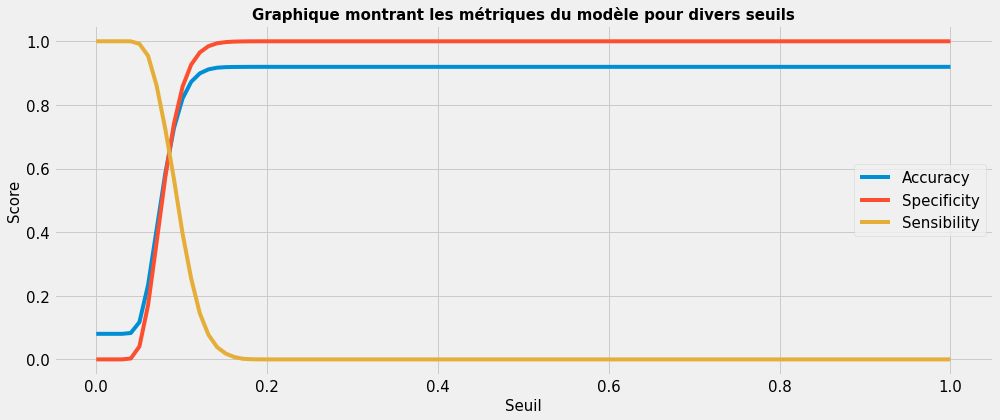

In [21]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



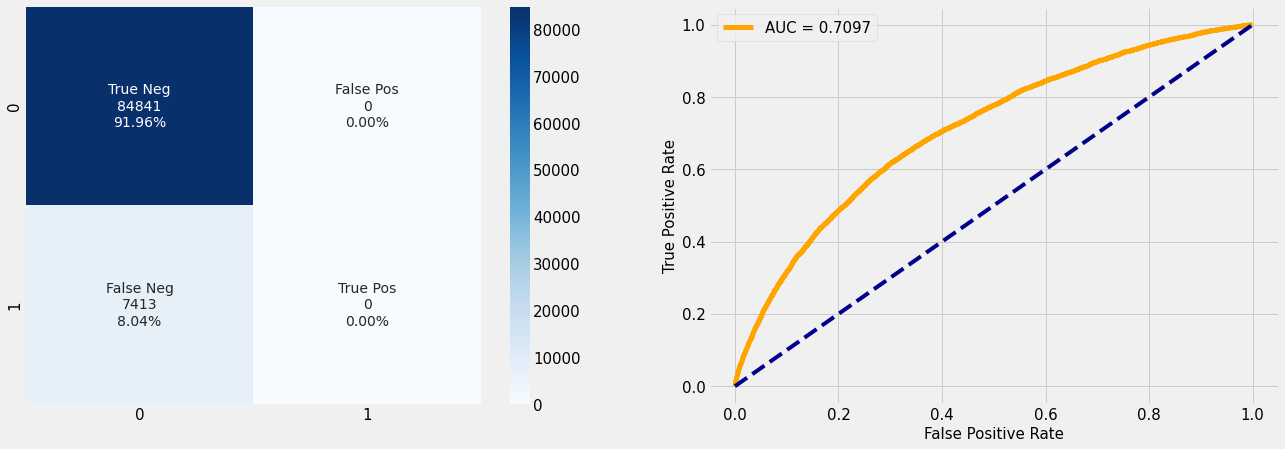

In [22]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling.predict(X_test)))
cf_matrix_roc_auc(log_modeling, y_test, log_modeling.predict(X_test), log_modeling.predict_proba(X_test)[:,1], feature_importances = None)

L'AUC est égal à 0.7097 qui signifie que ce modèle à une probabilité de 70,97% de distinguer correctement une classe négative d'une classe positive. En effet, notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

In [23]:
# Instanciation de l'algorithme
log_modeling_res = LogisticRegression(C = 0.0001, max_iter=100)

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_res.fit(X_train_res, y_train_res)

LogisticRegression(C=0.0001)

In [24]:
# Métriques de log_model pour divers seuils
df_metrics_model_res = print_results(log_modeling_res)
df_metrics_model_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.0,0.0,1.0
1,0.010101,0.080354,1.0,0.0,1.0
2,0.020202,0.080354,1.0,0.0,1.0
3,0.030303,0.080354,1.0,0.0,1.0
4,0.040404,0.080354,1.0,0.0,1.0


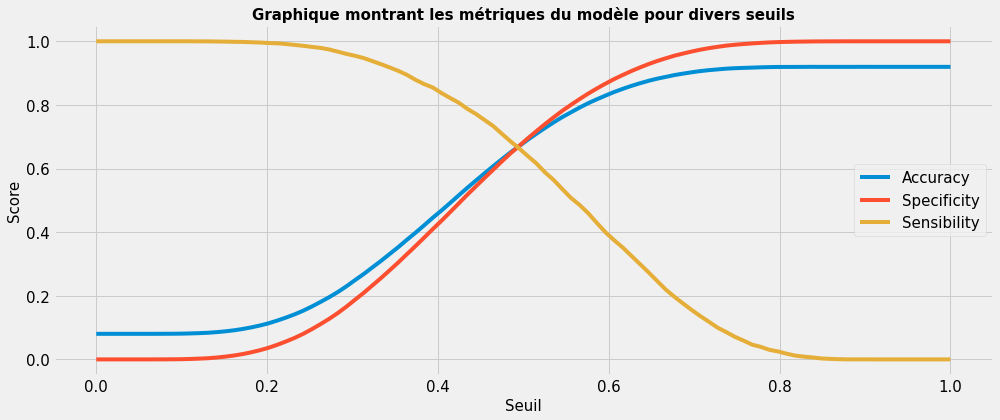

In [25]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_res)

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80     84841
         1.0       0.15      0.65      0.25      7413

    accuracy                           0.68     92254
   macro avg       0.56      0.67      0.52     92254
weighted avg       0.89      0.68      0.75     92254



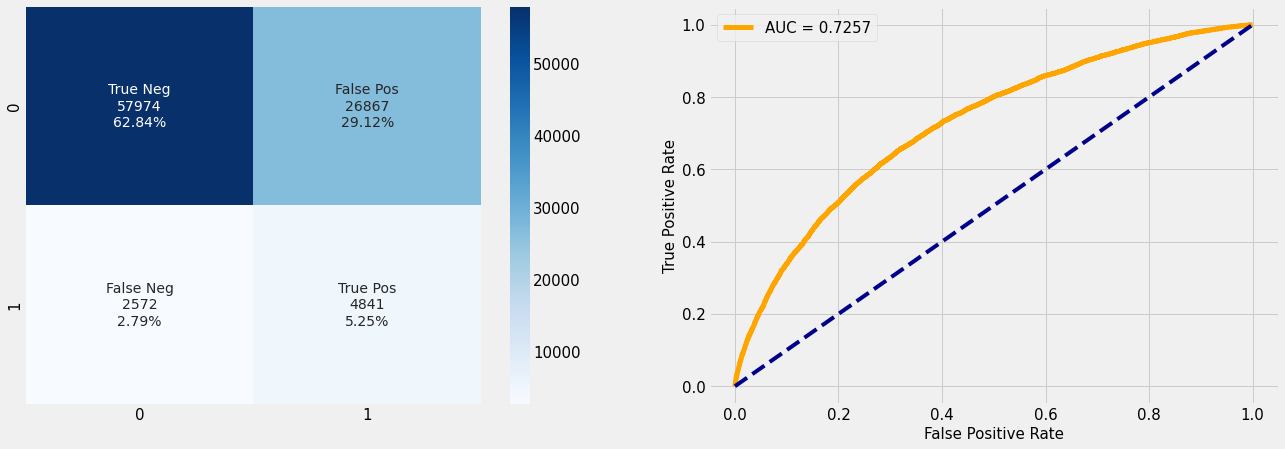

In [26]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_res, y_test, log_modeling_res.predict(X_test), log_modeling_res.predict_proba(X_test)[:,1], feature_importances = None)

Les courbes de score de classification, de sensiblité et de spécificité viennent se couper très proche d'un seui de 0,5. Cette ,ituation est différente de la courbe obtenu avec le modèle entraîné sur les données déséquilibrées où le point d'enterception est même inférieur à 0,2. On obserse une améloration de la performance du modèle sur les données équilibrées. Le modèle à une probabilité de 72,57% de distiquer une classe positive comme étant un classe positive et une classe négative comme étant une classe négative. Nous prendrons comme baseline de travail pour la suite des essais…

### <span style="color:#39ac39"> 4-2 Algorithme CatBoostClassifier </span>

In [27]:
#Import de l' algorithme
from catboost import CatBoostClassifier

In [28]:
# Instanciation de l'algorithme
log_catboost = CatBoostClassifier()

In [29]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_catboost.fit(X_train, y_train)

Learning rate set to 0.102119
0:	learn: 0.5955118	total: 1.71s	remaining: 28m 32s
1:	learn: 0.5221672	total: 1.9s	remaining: 15m 49s
2:	learn: 0.4592741	total: 2.18s	remaining: 12m 3s
3:	learn: 0.4161858	total: 2.46s	remaining: 10m 11s
4:	learn: 0.3786738	total: 2.76s	remaining: 9m 9s
5:	learn: 0.3545694	total: 3s	remaining: 8m 16s
6:	learn: 0.3326514	total: 3.28s	remaining: 7m 45s
7:	learn: 0.3175693	total: 3.62s	remaining: 7m 29s
8:	learn: 0.3042365	total: 3.89s	remaining: 7m 8s
9:	learn: 0.2941561	total: 4.17s	remaining: 6m 53s
10:	learn: 0.2862919	total: 4.45s	remaining: 6m 40s
11:	learn: 0.2801228	total: 4.74s	remaining: 6m 30s
12:	learn: 0.2749582	total: 5.01s	remaining: 6m 20s
13:	learn: 0.2707444	total: 5.39s	remaining: 6m 19s
14:	learn: 0.2674234	total: 5.63s	remaining: 6m 9s
15:	learn: 0.2648235	total: 5.87s	remaining: 6m
16:	learn: 0.2628012	total: 6.11s	remaining: 5m 53s
17:	learn: 0.2610294	total: 6.4s	remaining: 5m 49s
18:	learn: 0.2593985	total: 6.67s	remaining: 5m 44s
1

158:	learn: 0.2342914	total: 49.8s	remaining: 4m 23s
159:	learn: 0.2342260	total: 50s	remaining: 4m 22s
160:	learn: 0.2341810	total: 50.3s	remaining: 4m 22s
161:	learn: 0.2341053	total: 50.6s	remaining: 4m 21s
162:	learn: 0.2340433	total: 50.9s	remaining: 4m 21s
163:	learn: 0.2339826	total: 51.2s	remaining: 4m 21s
164:	learn: 0.2338938	total: 51.6s	remaining: 4m 20s
165:	learn: 0.2338288	total: 51.9s	remaining: 4m 20s
166:	learn: 0.2337548	total: 52.2s	remaining: 4m 20s
167:	learn: 0.2336914	total: 52.8s	remaining: 4m 21s
168:	learn: 0.2336148	total: 53.3s	remaining: 4m 22s
169:	learn: 0.2336113	total: 53.5s	remaining: 4m 21s
170:	learn: 0.2335087	total: 53.9s	remaining: 4m 21s
171:	learn: 0.2334566	total: 54.1s	remaining: 4m 20s
172:	learn: 0.2333901	total: 54.4s	remaining: 4m 20s
173:	learn: 0.2333860	total: 54.6s	remaining: 4m 19s
174:	learn: 0.2333276	total: 54.8s	remaining: 4m 18s
175:	learn: 0.2332709	total: 55s	remaining: 4m 17s
176:	learn: 0.2332672	total: 55.2s	remaining: 4m 1

312:	learn: 0.2261974	total: 1m 39s	remaining: 3m 38s
313:	learn: 0.2261465	total: 1m 39s	remaining: 3m 37s
314:	learn: 0.2261046	total: 1m 39s	remaining: 3m 37s
315:	learn: 0.2260562	total: 1m 40s	remaining: 3m 36s
316:	learn: 0.2260082	total: 1m 40s	remaining: 3m 36s
317:	learn: 0.2259613	total: 1m 40s	remaining: 3m 36s
318:	learn: 0.2259029	total: 1m 41s	remaining: 3m 35s
319:	learn: 0.2258658	total: 1m 41s	remaining: 3m 35s
320:	learn: 0.2258066	total: 1m 41s	remaining: 3m 35s
321:	learn: 0.2257553	total: 1m 41s	remaining: 3m 34s
322:	learn: 0.2256892	total: 1m 42s	remaining: 3m 34s
323:	learn: 0.2256463	total: 1m 42s	remaining: 3m 33s
324:	learn: 0.2255924	total: 1m 42s	remaining: 3m 33s
325:	learn: 0.2255486	total: 1m 43s	remaining: 3m 32s
326:	learn: 0.2254937	total: 1m 43s	remaining: 3m 32s
327:	learn: 0.2254347	total: 1m 43s	remaining: 3m 32s
328:	learn: 0.2253887	total: 1m 43s	remaining: 3m 31s
329:	learn: 0.2253347	total: 1m 44s	remaining: 3m 31s
330:	learn: 0.2252952	total:

466:	learn: 0.2195981	total: 2m 23s	remaining: 2m 43s
467:	learn: 0.2195487	total: 2m 23s	remaining: 2m 43s
468:	learn: 0.2195235	total: 2m 24s	remaining: 2m 43s
469:	learn: 0.2194649	total: 2m 24s	remaining: 2m 42s
470:	learn: 0.2194427	total: 2m 24s	remaining: 2m 42s
471:	learn: 0.2193910	total: 2m 24s	remaining: 2m 42s
472:	learn: 0.2193498	total: 2m 25s	remaining: 2m 41s
473:	learn: 0.2193126	total: 2m 25s	remaining: 2m 41s
474:	learn: 0.2192756	total: 2m 25s	remaining: 2m 41s
475:	learn: 0.2192374	total: 2m 26s	remaining: 2m 40s
476:	learn: 0.2191899	total: 2m 26s	remaining: 2m 40s
477:	learn: 0.2191542	total: 2m 26s	remaining: 2m 40s
478:	learn: 0.2191493	total: 2m 26s	remaining: 2m 39s
479:	learn: 0.2191138	total: 2m 26s	remaining: 2m 39s
480:	learn: 0.2190836	total: 2m 27s	remaining: 2m 38s
481:	learn: 0.2190511	total: 2m 27s	remaining: 2m 38s
482:	learn: 0.2189832	total: 2m 27s	remaining: 2m 38s
483:	learn: 0.2189532	total: 2m 27s	remaining: 2m 37s
484:	learn: 0.2189189	total:

619:	learn: 0.2138499	total: 3m 3s	remaining: 1m 52s
620:	learn: 0.2138004	total: 3m 3s	remaining: 1m 51s
621:	learn: 0.2137680	total: 3m 3s	remaining: 1m 51s
622:	learn: 0.2137296	total: 3m 3s	remaining: 1m 51s
623:	learn: 0.2137045	total: 3m 3s	remaining: 1m 50s
624:	learn: 0.2136824	total: 3m 4s	remaining: 1m 50s
625:	learn: 0.2136616	total: 3m 4s	remaining: 1m 50s
626:	learn: 0.2136311	total: 3m 4s	remaining: 1m 49s
627:	learn: 0.2136084	total: 3m 4s	remaining: 1m 49s
628:	learn: 0.2135719	total: 3m 5s	remaining: 1m 49s
629:	learn: 0.2135231	total: 3m 5s	remaining: 1m 48s
630:	learn: 0.2134794	total: 3m 5s	remaining: 1m 48s
631:	learn: 0.2134582	total: 3m 5s	remaining: 1m 48s
632:	learn: 0.2134167	total: 3m 6s	remaining: 1m 47s
633:	learn: 0.2133968	total: 3m 6s	remaining: 1m 47s
634:	learn: 0.2133647	total: 3m 6s	remaining: 1m 47s
635:	learn: 0.2133331	total: 3m 6s	remaining: 1m 46s
636:	learn: 0.2132900	total: 3m 6s	remaining: 1m 46s
637:	learn: 0.2132506	total: 3m 7s	remaining: 

773:	learn: 0.2085030	total: 3m 45s	remaining: 1m 5s
774:	learn: 0.2084875	total: 3m 45s	remaining: 1m 5s
775:	learn: 0.2084468	total: 3m 45s	remaining: 1m 5s
776:	learn: 0.2083938	total: 3m 45s	remaining: 1m 4s
777:	learn: 0.2083806	total: 3m 46s	remaining: 1m 4s
778:	learn: 0.2083534	total: 3m 46s	remaining: 1m 4s
779:	learn: 0.2083054	total: 3m 46s	remaining: 1m 3s
780:	learn: 0.2082912	total: 3m 46s	remaining: 1m 3s
781:	learn: 0.2082697	total: 3m 47s	remaining: 1m 3s
782:	learn: 0.2082322	total: 3m 47s	remaining: 1m 3s
783:	learn: 0.2081832	total: 3m 47s	remaining: 1m 2s
784:	learn: 0.2081500	total: 3m 48s	remaining: 1m 2s
785:	learn: 0.2081013	total: 3m 48s	remaining: 1m 2s
786:	learn: 0.2080686	total: 3m 48s	remaining: 1m 1s
787:	learn: 0.2080231	total: 3m 48s	remaining: 1m 1s
788:	learn: 0.2079960	total: 3m 49s	remaining: 1m 1s
789:	learn: 0.2079648	total: 3m 49s	remaining: 1m
790:	learn: 0.2079459	total: 3m 49s	remaining: 1m
791:	learn: 0.2079302	total: 3m 50s	remaining: 1m
79

930:	learn: 0.2033178	total: 4m 34s	remaining: 20.3s
931:	learn: 0.2032770	total: 4m 34s	remaining: 20s
932:	learn: 0.2032379	total: 4m 34s	remaining: 19.7s
933:	learn: 0.2031952	total: 4m 35s	remaining: 19.4s
934:	learn: 0.2031708	total: 4m 35s	remaining: 19.1s
935:	learn: 0.2031424	total: 4m 35s	remaining: 18.8s
936:	learn: 0.2031047	total: 4m 35s	remaining: 18.6s
937:	learn: 0.2030559	total: 4m 36s	remaining: 18.3s
938:	learn: 0.2030478	total: 4m 36s	remaining: 18s
939:	learn: 0.2030205	total: 4m 36s	remaining: 17.7s
940:	learn: 0.2029790	total: 4m 37s	remaining: 17.4s
941:	learn: 0.2029468	total: 4m 37s	remaining: 17.1s
942:	learn: 0.2029400	total: 4m 37s	remaining: 16.8s
943:	learn: 0.2029122	total: 4m 38s	remaining: 16.5s
944:	learn: 0.2028889	total: 4m 38s	remaining: 16.2s
945:	learn: 0.2028609	total: 4m 38s	remaining: 15.9s
946:	learn: 0.2028399	total: 4m 38s	remaining: 15.6s
947:	learn: 0.2027919	total: 4m 39s	remaining: 15.3s
948:	learn: 0.2027395	total: 4m 39s	remaining: 15s

In [30]:
# Métriques de log_model pour divers seuils
df_metrics_model_cat = print_results(log_catboost)
df_metrics_model_cat.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.134097,0.995279,0.058851,0.941149
2,0.020202,0.273105,0.967759,0.212409,0.787591
3,0.030303,0.402844,0.931472,0.356655,0.643345
4,0.040404,0.504141,0.883988,0.470952,0.529048


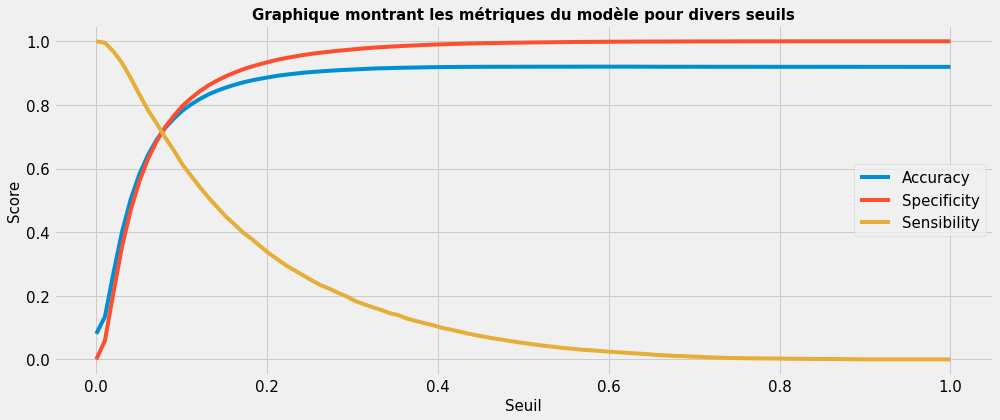

In [31]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_cat)

In [32]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_catboost.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_catboost.predict(X_test)))
cf_matrix_roc_auc(log_catboost, y_test, log_catboost.predict(X_test), log_catboost.predict_proba(X_test)[:,1], feature_importances = None)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.53      0.05      0.09      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



KeyboardInterrupt: 

**Oversampling Data Using SMOTE**

In [83]:
# Instanciation de l'algorithme
log_modeling_catboost_res = CatBoostClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_catboost_res.fit(X_train_res, y_train_res)

Learning rate set to 0.132436
0:	learn: 0.6066927	total: 1.49s	remaining: 24m 50s
1:	learn: 0.5710167	total: 2.12s	remaining: 17m 38s
2:	learn: 0.5432528	total: 2.77s	remaining: 15m 19s
3:	learn: 0.4961675	total: 3.34s	remaining: 13m 51s
4:	learn: 0.4453306	total: 4.03s	remaining: 13m 22s
5:	learn: 0.4304199	total: 4.74s	remaining: 13m 5s
6:	learn: 0.4167989	total: 5.32s	remaining: 12m 34s
7:	learn: 0.3909045	total: 5.91s	remaining: 12m 12s
8:	learn: 0.3628263	total: 6.58s	remaining: 12m 4s
9:	learn: 0.3476638	total: 7.19s	remaining: 11m 51s
10:	learn: 0.3209585	total: 7.82s	remaining: 11m 42s
11:	learn: 0.3127424	total: 8.47s	remaining: 11m 37s
12:	learn: 0.2868553	total: 9.07s	remaining: 11m 28s
13:	learn: 0.2701275	total: 9.61s	remaining: 11m 17s
14:	learn: 0.2644060	total: 10.1s	remaining: 11m 4s
15:	learn: 0.2545512	total: 10.8s	remaining: 11m 3s
16:	learn: 0.2494410	total: 11.3s	remaining: 10m 53s
17:	learn: 0.2366813	total: 11.8s	remaining: 10m 44s
18:	learn: 0.2257289	total: 12

156:	learn: 0.1354971	total: 1m 33s	remaining: 8m 22s
157:	learn: 0.1354125	total: 1m 34s	remaining: 8m 21s
158:	learn: 0.1353404	total: 1m 34s	remaining: 8m 21s
159:	learn: 0.1352784	total: 1m 35s	remaining: 8m 20s
160:	learn: 0.1352335	total: 1m 35s	remaining: 8m 19s
161:	learn: 0.1351804	total: 1m 36s	remaining: 8m 18s
162:	learn: 0.1348152	total: 1m 36s	remaining: 8m 17s
163:	learn: 0.1347685	total: 1m 37s	remaining: 8m 16s
164:	learn: 0.1347352	total: 1m 37s	remaining: 8m 15s
165:	learn: 0.1346796	total: 1m 38s	remaining: 8m 13s
166:	learn: 0.1346061	total: 1m 39s	remaining: 8m 14s
167:	learn: 0.1345695	total: 1m 39s	remaining: 8m 12s
168:	learn: 0.1345034	total: 1m 40s	remaining: 8m 11s
169:	learn: 0.1344557	total: 1m 40s	remaining: 8m 10s
170:	learn: 0.1344161	total: 1m 41s	remaining: 8m 9s
171:	learn: 0.1343480	total: 1m 41s	remaining: 8m 9s
172:	learn: 0.1342979	total: 1m 42s	remaining: 8m 8s
173:	learn: 0.1342348	total: 1m 42s	remaining: 8m 8s
174:	learn: 0.1341975	total: 1m 

309:	learn: 0.1281506	total: 2m 53s	remaining: 6m 26s
310:	learn: 0.1281172	total: 2m 54s	remaining: 6m 26s
311:	learn: 0.1280684	total: 2m 54s	remaining: 6m 25s
312:	learn: 0.1280240	total: 2m 55s	remaining: 6m 25s
313:	learn: 0.1279691	total: 2m 55s	remaining: 6m 24s
314:	learn: 0.1279280	total: 2m 56s	remaining: 6m 23s
315:	learn: 0.1278921	total: 2m 56s	remaining: 6m 22s
316:	learn: 0.1278504	total: 2m 57s	remaining: 6m 22s
317:	learn: 0.1278077	total: 2m 57s	remaining: 6m 21s
318:	learn: 0.1277609	total: 2m 58s	remaining: 6m 20s
319:	learn: 0.1277341	total: 2m 58s	remaining: 6m 19s
320:	learn: 0.1277051	total: 2m 59s	remaining: 6m 19s
321:	learn: 0.1276655	total: 2m 59s	remaining: 6m 18s
322:	learn: 0.1276319	total: 3m	remaining: 6m 18s
323:	learn: 0.1276165	total: 3m	remaining: 6m 17s
324:	learn: 0.1275875	total: 3m 1s	remaining: 6m 17s
325:	learn: 0.1275447	total: 3m 2s	remaining: 6m 16s
326:	learn: 0.1275228	total: 3m 2s	remaining: 6m 16s
327:	learn: 0.1275204	total: 3m 3s	rema

463:	learn: 0.1228247	total: 4m 10s	remaining: 4m 49s
464:	learn: 0.1227892	total: 4m 11s	remaining: 4m 49s
465:	learn: 0.1227686	total: 4m 11s	remaining: 4m 48s
466:	learn: 0.1227428	total: 4m 12s	remaining: 4m 47s
467:	learn: 0.1227061	total: 4m 12s	remaining: 4m 47s
468:	learn: 0.1226876	total: 4m 13s	remaining: 4m 46s
469:	learn: 0.1226471	total: 4m 13s	remaining: 4m 45s
470:	learn: 0.1226301	total: 4m 14s	remaining: 4m 45s
471:	learn: 0.1225997	total: 4m 14s	remaining: 4m 45s
472:	learn: 0.1225763	total: 4m 15s	remaining: 4m 44s
473:	learn: 0.1225425	total: 4m 15s	remaining: 4m 44s
474:	learn: 0.1225203	total: 4m 16s	remaining: 4m 43s
475:	learn: 0.1224816	total: 4m 17s	remaining: 4m 42s
476:	learn: 0.1224634	total: 4m 17s	remaining: 4m 42s
477:	learn: 0.1224424	total: 4m 18s	remaining: 4m 41s
478:	learn: 0.1224207	total: 4m 18s	remaining: 4m 41s
479:	learn: 0.1223959	total: 4m 18s	remaining: 4m 40s
480:	learn: 0.1223761	total: 4m 19s	remaining: 4m 39s
481:	learn: 0.1223403	total:

616:	learn: 0.1187234	total: 5m 28s	remaining: 3m 23s
617:	learn: 0.1186863	total: 5m 28s	remaining: 3m 23s
618:	learn: 0.1186612	total: 5m 29s	remaining: 3m 22s
619:	learn: 0.1186426	total: 5m 30s	remaining: 3m 22s
620:	learn: 0.1186106	total: 5m 30s	remaining: 3m 21s
621:	learn: 0.1185834	total: 5m 31s	remaining: 3m 21s
622:	learn: 0.1185722	total: 5m 32s	remaining: 3m 21s
623:	learn: 0.1184220	total: 5m 32s	remaining: 3m 20s
624:	learn: 0.1183983	total: 5m 33s	remaining: 3m 19s
625:	learn: 0.1183587	total: 5m 34s	remaining: 3m 19s
626:	learn: 0.1183342	total: 5m 34s	remaining: 3m 19s
627:	learn: 0.1183162	total: 5m 35s	remaining: 3m 18s
628:	learn: 0.1182958	total: 5m 35s	remaining: 3m 17s
629:	learn: 0.1182677	total: 5m 36s	remaining: 3m 17s
630:	learn: 0.1182477	total: 5m 36s	remaining: 3m 16s
631:	learn: 0.1182125	total: 5m 37s	remaining: 3m 16s
632:	learn: 0.1181868	total: 5m 37s	remaining: 3m 15s
633:	learn: 0.1181672	total: 5m 38s	remaining: 3m 15s
634:	learn: 0.1181416	total:

769:	learn: 0.1149602	total: 6m 47s	remaining: 2m 1s
770:	learn: 0.1149333	total: 6m 47s	remaining: 2m 1s
771:	learn: 0.1149152	total: 6m 48s	remaining: 2m
772:	learn: 0.1148972	total: 6m 48s	remaining: 1m 59s
773:	learn: 0.1148921	total: 6m 49s	remaining: 1m 59s
774:	learn: 0.1148749	total: 6m 49s	remaining: 1m 58s
775:	learn: 0.1148499	total: 6m 50s	remaining: 1m 58s
776:	learn: 0.1148175	total: 6m 50s	remaining: 1m 57s
777:	learn: 0.1148091	total: 6m 51s	remaining: 1m 57s
778:	learn: 0.1147916	total: 6m 51s	remaining: 1m 56s
779:	learn: 0.1147692	total: 6m 52s	remaining: 1m 56s
780:	learn: 0.1147552	total: 6m 52s	remaining: 1m 55s
781:	learn: 0.1147312	total: 6m 53s	remaining: 1m 55s
782:	learn: 0.1147172	total: 6m 53s	remaining: 1m 54s
783:	learn: 0.1146895	total: 6m 54s	remaining: 1m 54s
784:	learn: 0.1146785	total: 6m 54s	remaining: 1m 53s
785:	learn: 0.1146566	total: 6m 55s	remaining: 1m 53s
786:	learn: 0.1146552	total: 6m 55s	remaining: 1m 52s
787:	learn: 0.1146346	total: 6m 56

923:	learn: 0.1116668	total: 8m 8s	remaining: 40.2s
924:	learn: 0.1116521	total: 8m 8s	remaining: 39.6s
925:	learn: 0.1116394	total: 8m 9s	remaining: 39.1s
926:	learn: 0.1116070	total: 8m 10s	remaining: 38.6s
927:	learn: 0.1115894	total: 8m 10s	remaining: 38.1s
928:	learn: 0.1115680	total: 8m 11s	remaining: 37.5s
929:	learn: 0.1115562	total: 8m 11s	remaining: 37s
930:	learn: 0.1115259	total: 8m 11s	remaining: 36.5s
931:	learn: 0.1115003	total: 8m 12s	remaining: 35.9s
932:	learn: 0.1114704	total: 8m 13s	remaining: 35.4s
933:	learn: 0.1114458	total: 8m 13s	remaining: 34.9s
934:	learn: 0.1114162	total: 8m 14s	remaining: 34.4s
935:	learn: 0.1113858	total: 8m 14s	remaining: 33.8s
936:	learn: 0.1113846	total: 8m 15s	remaining: 33.3s
937:	learn: 0.1113537	total: 8m 16s	remaining: 32.8s
938:	learn: 0.1113245	total: 8m 16s	remaining: 32.3s
939:	learn: 0.1112954	total: 8m 17s	remaining: 31.7s
940:	learn: 0.1112731	total: 8m 17s	remaining: 31.2s
941:	learn: 0.1112475	total: 8m 18s	remaining: 30.7

In [84]:
# Métriques de log_model pour divers seuils
df_metrics_model_catboost_res = print_results(log_modeling_catboost_res)
df_metrics_model_catboost_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.00000,0.000000,1.000000
1,0.010101,0.148134,0.99312,0.074304,0.925696
2,0.020202,0.276096,0.96695,0.215733,0.784267
3,0.030303,0.391907,0.92729,0.345128,0.654872
4,0.040404,0.485605,0.88790,0.450454,0.549546


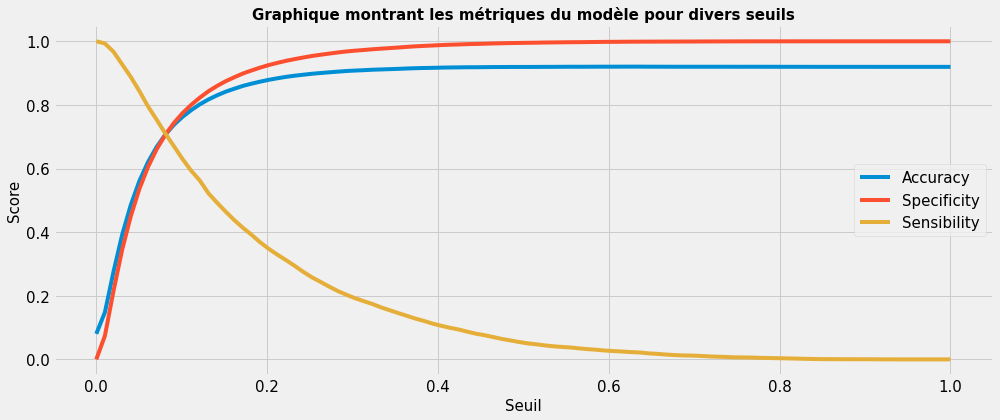

In [85]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_catboost_res)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.48      0.05      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



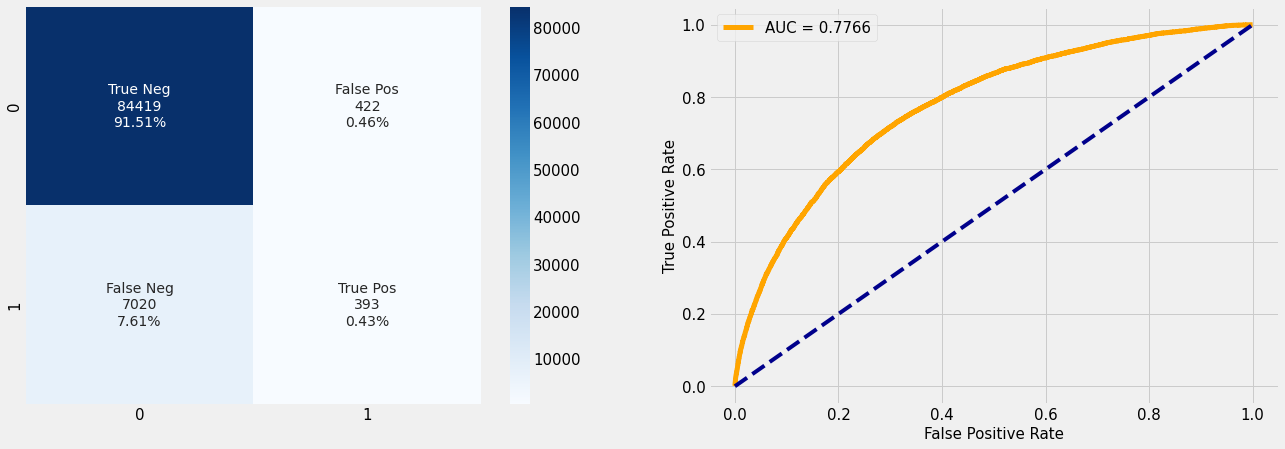

In [86]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_catboost_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_catboost_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_catboost_res, y_test, log_modeling_catboost_res.predict(X_test), log_modeling_catboost_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-3 Algorithme LGBMClassifier </span>

In [23]:
#Import de l' algorithme
from lightgbm import LGBMClassifier

In [24]:
# Instanciation de l'algorithme
log_LGBM = LGBMClassifier()

In [25]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_LGBM.fit(X_train, y_train)

LGBMClassifier()

In [26]:
# Métriques de log_model pour divers seuils
df_metrics_model_lgbm = print_results(log_LGBM)
df_metrics_model_lgbm.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.089535,0.999730,0.010007,0.989993
2,0.020202,0.211492,0.983003,0.144081,0.855919
3,0.030303,0.363616,0.943747,0.312927,0.687073
4,0.040404,0.481844,0.891407,0.446058,0.553942


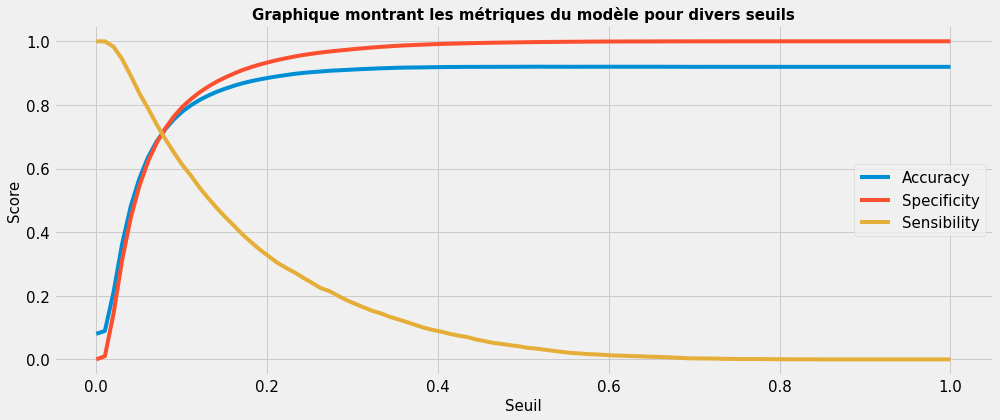

In [27]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_lgbm)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.53      0.04      0.07      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.52      0.52     92254
weighted avg       0.89      0.92      0.89     92254



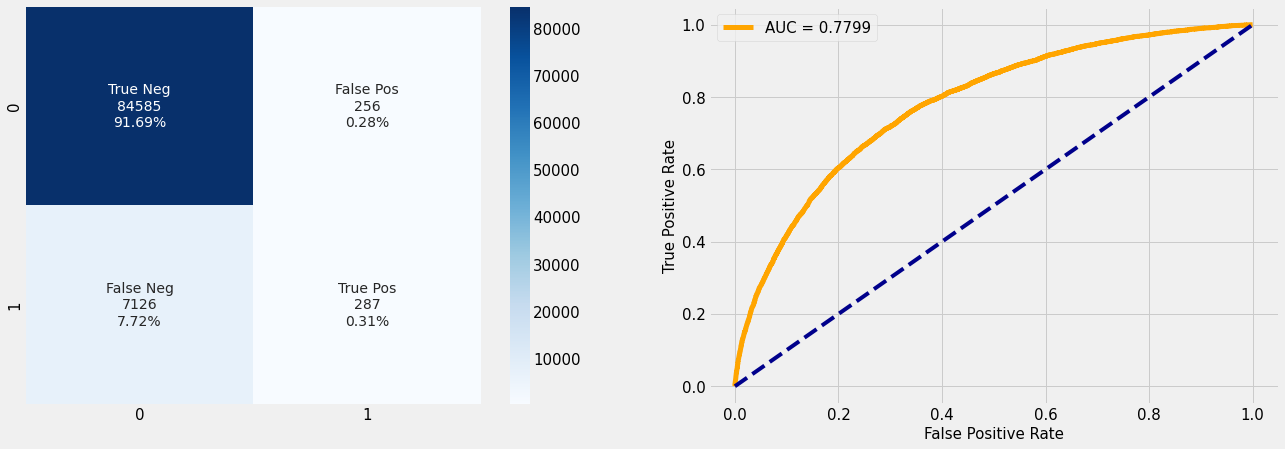

In [28]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_LGBM.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_LGBM.predict(X_test)))
cf_matrix_roc_auc(log_LGBM, y_test, log_LGBM.predict(X_test), log_LGBM.predict_proba(X_test)[:,1], feature_importances = None)

**Oversampling Data Using SMOTE**

In [29]:
# Instanciation de l'algorithme
log_modeling_LGBM_res = LGBMClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_LGBM_res.fit(X_train_res, y_train_res)

LGBMClassifier()

In [30]:
# Métriques de log_model pour divers seuils
df_metrics_model_LGBM_res = print_results(log_modeling_LGBM_res)
df_metrics_model_LGBM_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.080885,1.000000,0.000578,0.999422
2,0.020202,0.132796,0.993525,0.057590,0.942410
3,0.030303,0.242721,0.971671,0.179029,0.820971
4,0.040404,0.351313,0.936733,0.300161,0.699839


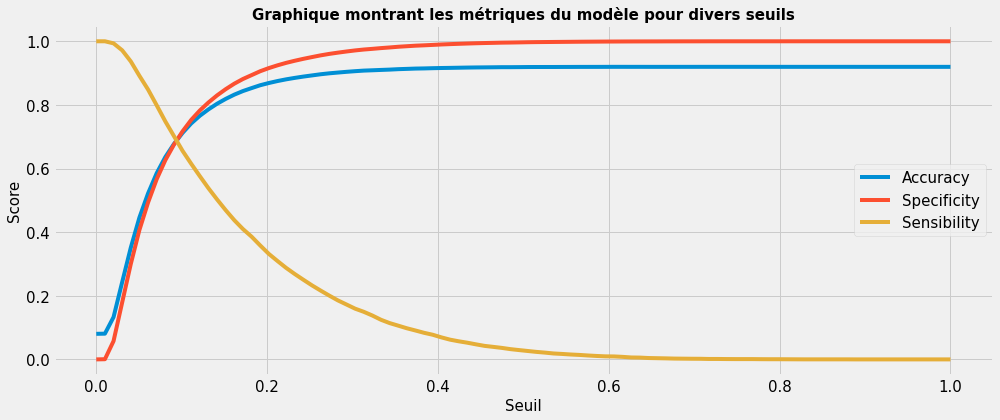

In [31]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_LGBM_res)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.43      0.03      0.05      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.51      0.51     92254
weighted avg       0.88      0.92      0.88     92254



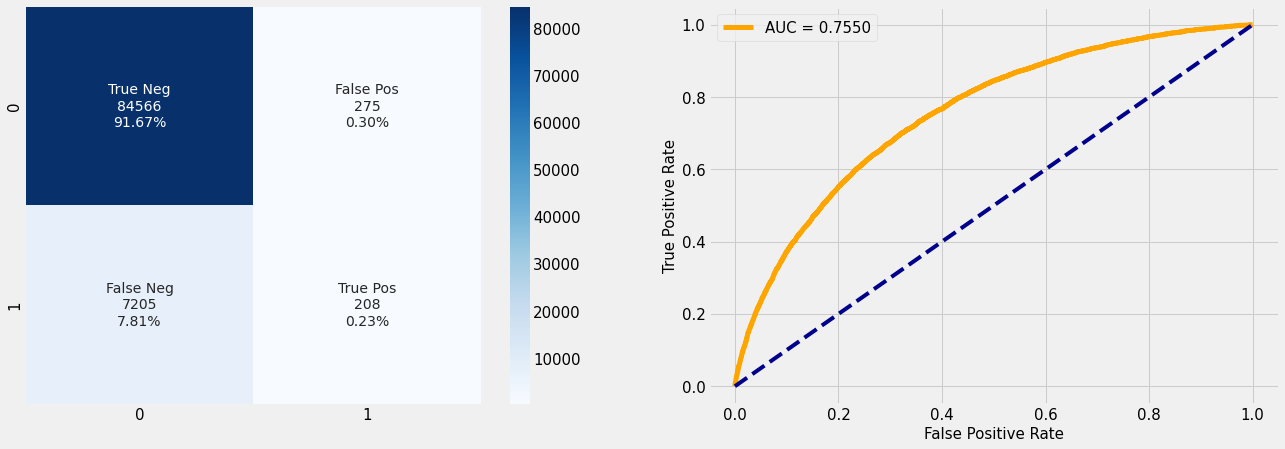

In [32]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_LGBM_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_LGBM_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_LGBM_res, y_test, log_modeling_LGBM_res.predict(X_test), log_modeling_LGBM_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-4 Algorithme XGBClassifier </span>

In [101]:
#Import de l' algorithme
from xgboost import XGBClassifier

In [102]:
# Instanciation de l'algorithme
log_XGB = XGBClassifier()

In [103]:
# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [104]:
# Métriques de log_model pour divers seuils
df_metrics_model_XGB = print_results(log_XGB)
df_metrics_model_XGB.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.164361,0.988803,0.092326,0.907674
2,0.020202,0.315835,0.953865,0.260087,0.739913
3,0.030303,0.442127,0.905436,0.401645,0.598355
4,0.040404,0.536996,0.856603,0.509070,0.490930


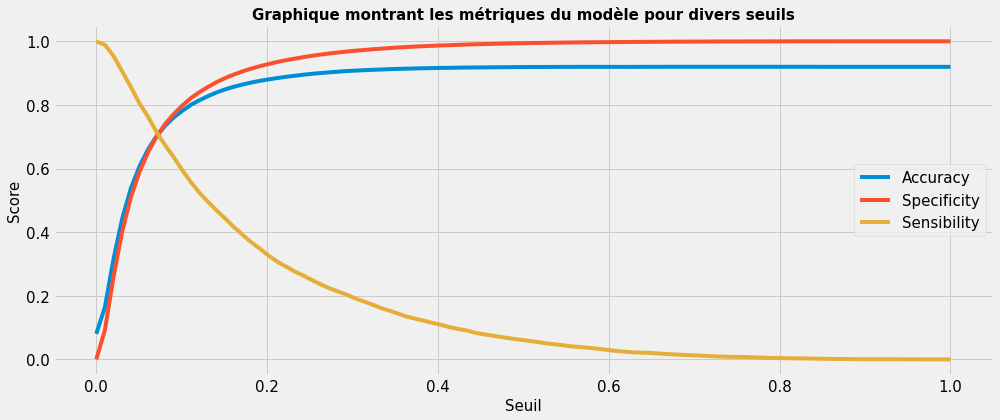

In [105]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_XGB)

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.47      0.06      0.11      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.53      0.53     92254
weighted avg       0.89      0.92      0.89     92254



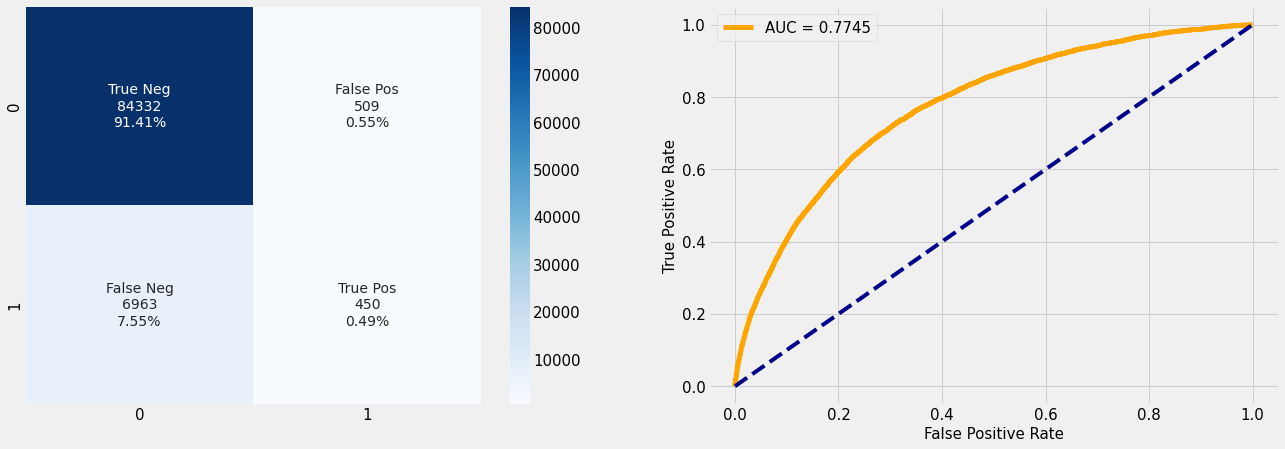

In [106]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_XGB.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_XGB.predict(X_test)))
cf_matrix_roc_auc(log_XGB, y_test, log_XGB.predict(X_test), log_XGB.predict_proba(X_test)[:,1], feature_importances = None)

**Oversampling Data Using SMOTE**

In [107]:
# Instanciation de l'algorithme
log_modeling_XGB_res = XGBClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_XGB_res.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [108]:
# Métriques de log_model pour divers seuils
df_metrics_model_XGB_res = print_results(log_modeling_XGB_res)
df_metrics_model_XGB_res.head(5)

,Valeur_Seuil,Score de classification,Sensibilité du modèle,Spécificité du modèle,1- Spécificité
0,0.000000,0.080354,1.000000,0.000000,1.000000
1,0.010101,0.180567,0.986240,0.110171,0.889829
2,0.020202,0.321926,0.943343,0.267630,0.732370
3,0.030303,0.433531,0.892351,0.393442,0.606558
4,0.040404,0.518568,0.844193,0.490117,0.509883


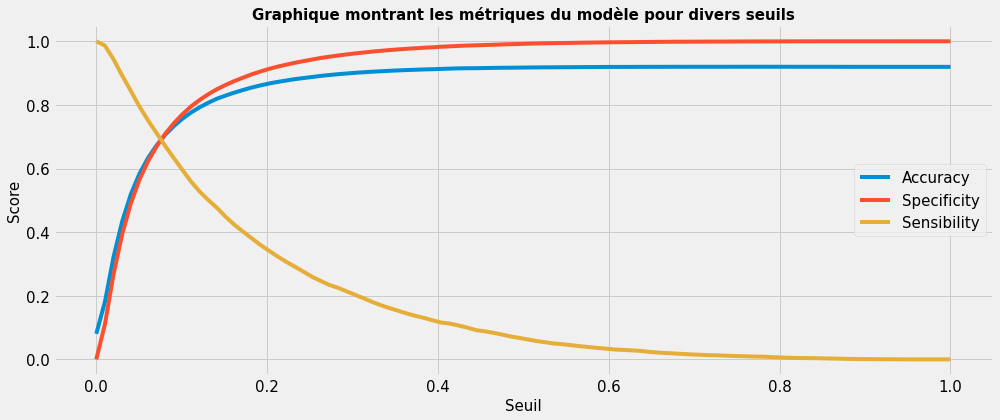

In [109]:
#Graphique montrant les métriques du modèle pour divers seuils
graphique_metrique(df_metrics_model_XGB_res)

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.41      0.07      0.11      7413

    accuracy                           0.92     92254
   macro avg       0.67      0.53      0.53     92254
weighted avg       0.88      0.92      0.89     92254



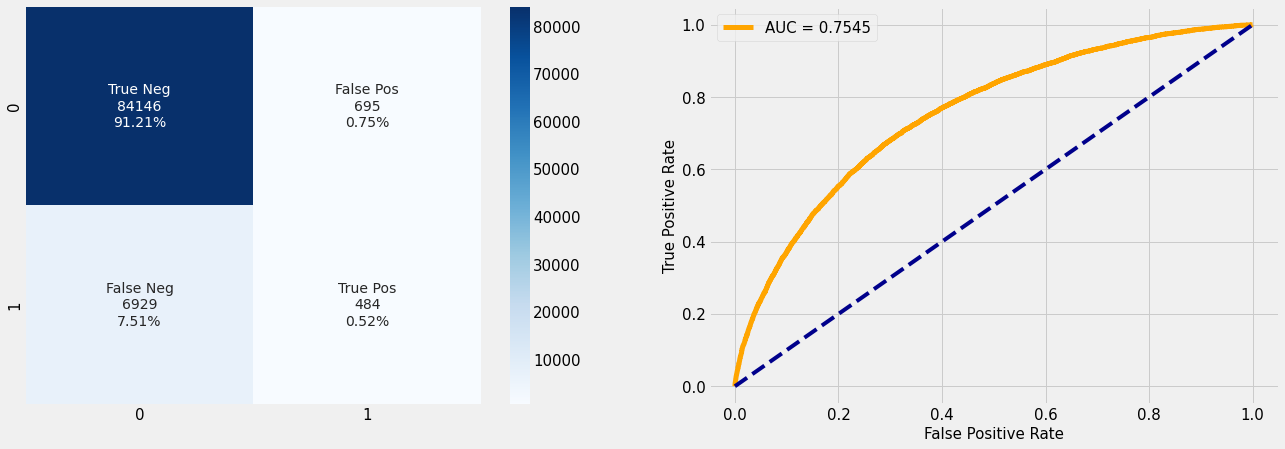

In [110]:
#Courbe de ROC
roc_auc = roc_auc_score(y_test, log_modeling_XGB_res.predict_proba(X_test)[:,1])
print(classification_report(y_test, log_modeling_XGB_res.predict(X_test)))
cf_matrix_roc_auc(log_modeling_XGB_res, y_test, log_modeling_XGB_res.predict(X_test), log_modeling_XGB_res.predict_proba(X_test)[:,1], feature_importances = None)

### <span style="color:#39ac39"> 4-5 Feature Selection - Recursive Feature Elimination </span>

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC  tout en éliminant les features les moins importantes.

#### Optimisation des différents algorithmes en utilisant la fonction GriSearchCV via la méthode de validation croisée

Un hyperparamètre est une donnée externe à l’algorithme ne pouvant être mise à jour lors des apprentissages. A cet effet, Pour trouver la valeur de l'hyperparamètre optimal dans le présent travail pour chaque algorithmes, nous allons utiliser la fonction GriSearchCV qui va ensuite utiliser les données d'apprentissage pour trouver la meilleure optimisation des hyperparamètres en utilisant la méthode de validation croisée. C’est-à-dire qu’elle va, dans notre cas, découper les données d’apprentissage en 5 groupes (CV=5), déterminer une optimisation sur les quatre premiers groupes et tester sur le cinquième.

In [43]:
###Importation du module
from sklearn.model_selection import GridSearchCV

In [114]:
###Instanciation de l'algorithme
log_modeling_LGBM = LGBMClassifier()

In [115]:
###Fixer les valeurs des hyperparamètres à tester
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [116]:
### Créer un regresseur avec recherche d'hyperparamètre par validation croisée
log_modeling_LGBM_Grid = GridSearchCV(log_modeling_LGBM, 
                                      gridParams, 
                                      verbose=1, 
                                      cv=5, 
                                      n_jobs=-1)

In [118]:
# Optimiser sur le jeu d'entraînement
#log_modeling_LGBM_Grid.fit(X_train, y_train)

In [33]:
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 504 features.
Fitting estimator with 499 features.
Fitting estimator with 494 features.
Fitting estimator with 489 features.
Fitting estimator with 484 features.
Fitting estimator with 479 features.
Fitting estimator with 474 features.
Fitting estimator with 469 features.
Fitting estimator with 464 features.
Fitting estimator with 459 features.
Fitting estimator with 454 features.
Fitting estimator with 449 features.
Fitting estimator with 444 features.
Fitting estimator with 439 features.
Fitting estimator with 434 features.
Fitting estimator with 429 features.
Fitting estimator with 424 features.
Fitting estimator with 419 features.
Fitting estimator with 414 features.
Fitting estimator with 409 features.
Fitting estimator with 404 features.
Fitting estimator with 399 features.
Fitting estimator with 394 features.
Fitting estimator with 389 features.
Fitting estimator with 384 features.
Fitting estimator with 379 features.
Fitting estimator with 374 features.
F

In [34]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 234
Selected Features: [ True  True False  True  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1 18  1  1  1  1  1  1  1  1  1  1  1 19 19  1 16  7 19]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [35]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

234
['NAME_CONTRACT_TYPE', 'CC_BAL_AMT_BALANCE', 'TY__Mortgage', 'CC_BAL_MONTHS_BALANCE', 'CC_BAL_SK_ID_PREV', 'AVG_PREV_PREVIOUS_APPLICATION_COUNT', 'AVG_PREV_AMT_ANNUITY', 'AVG_PREV_AMT_APPLICATION', 'AVG_PREV_AMT_CREDIT', 'AVG_PREV_AMT_DOWN_PAYMENT', 'AVG_PREV_AMT_GOODS_PRICE', 'AVG_PREV_HOUR_APPR_PROCESS_START', 'AVG_PREV_PRODUCT_COMBINATION_POS mobile without interest', 'AVG_PREV_NFLAG_LAST_APPL_IN_DAY', 'AVG_PREV_RATE_DOWN_PAYMENT', 'AVG_PREV_PRODUCT_COMBINATION_POS industry with interest', 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: middle', 'AVG_PREV_DAYS_DECISION', 'AVG_PREV_SELLERPLACE_AREA', 'AVG_PREV_CNT_PAYMENT', 'AVG_PREV_DAYS_FIRST_DRAWING', 'AVG_PREV_DAYS_FIRST_DUE', 'AVG_PREV_DAYS_LAST_DUE_1ST_VERSION', 'AVG_PREV_DAYS_LAST_DUE', 'AVG_PREV_DAYS_TERMINATION', 'AVG_PREV_NFLAG_INSURED_ON_APPROVAL', 'TY__Microloan', 'AVG_PREV_PRODUCT_COMBINATION_Cash X-Sell: low', 'CC_BAL_AMT_CREDIT_LIMIT_ACTUAL', 'WALLSMATERIAL_MODE_Panel', 'AVG_BURO_MONTHS_BALANCE_MEAN', 'AVG_BURO_BURO_BAL

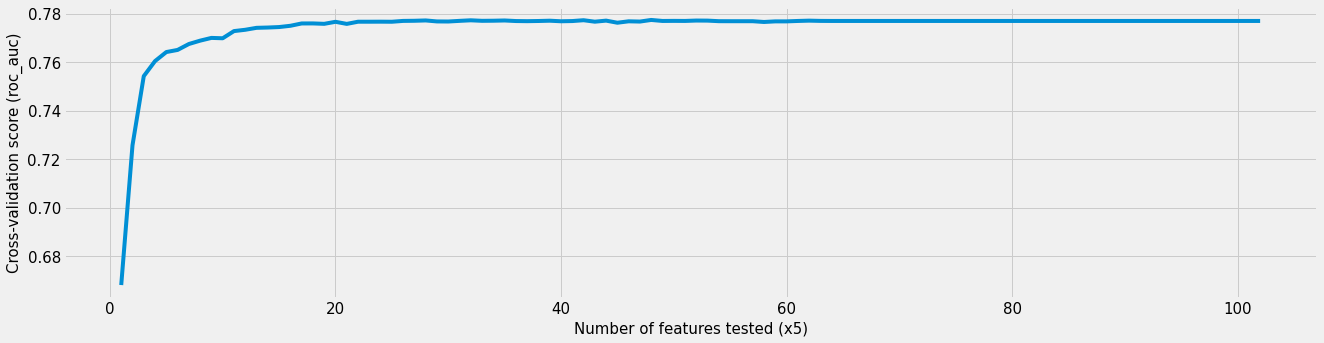

In [36]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

In [37]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 234)

In [38]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [39]:
X_data.shape

(307511, 235)

In [40]:
X_data.head(5)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,ENTRANCES_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,COMMONAREA_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AVG_BURO_MONTHS_BALANCE_MEAN,AVG_BURO_BURO_BAL_STATUS_0,AVG_BURO_BURO_BAL_STATUS_1,AVG_BURO_BURO_BAL_STATUS_2,AVG_BURO_BURO_BAL_STATUS_4,AVG_BURO_BURO_BAL_STATUS_5,AVG_BURO_BURO_BAL_STATUS_C,AVG_BURO_BURO_BAL_STATUS_X,AVG_BURO_buro_count,CA__Active,CA__Closed,CA__Sold,TY__Car loan,TY__Consumer credit,TY__Microloan,TY__Mortgage,AVG_PREV_PREVIOUS_APPLICATION_COUNT,AVG_PREV_AMT_ANNUITY,AVG_PREV_AMT_APPLICATION,AVG_PREV_AMT_CREDIT,AVG_PREV_AMT_DOWN_PAYMENT,AVG_PREV_AMT_GOODS_PRICE,AVG_PREV_HOUR_APPR_PROCESS_START,AVG_PREV_NFLAG_LAST_APPL_IN_DAY,AVG_PREV_RATE_DOWN_PAYMENT,AVG_PREV_DAYS_DECISION,AVG_PREV_SELLERPLACE_AREA,AVG_PREV_CNT_PAYMENT,AVG_PREV_DAYS_FIRST_DRAWING,AVG_PREV_DAYS_FIRST_DUE,AVG_PREV_DAYS_LAST_DUE_1ST_VERSION,AVG_PREV_DAYS_LAST_DUE,AVG_PREV_DAYS_TERMINATION,AVG_PREV_NFLAG_INSURED_ON_APPROVAL,AVG_PREV_NAME_CONTRACT_TYPE_Consumer loans,AVG_PREV_NAME_CONTRACT_TYPE_Revolving loans,AVG_PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_MONDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY,AVG_PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Other,AVG_PREV_NAME_CASH_LOAN_PURPOSE_Repairs,AVG_PREV_NAME_CONTRACT_STATUS_Approved,AVG_PREV_NAME_CONTRACT_STATUS_Canceled,AVG_PREV_NAME_CONTRACT_STATUS_Refused,AVG_PREV_NAME_PAYMENT_TYPE_Cash through the bank,AVG_PREV_NAME_PAYMENT_TYPE_XNA,AVG_PREV_CODE_REJECT_REASON_HC,AVG_PREV_CODE_REJECT_REASON_LIMIT,AVG_PREV_CODE_REJECT_REASON_XAP,AVG_PREV_NAME_TYPE_SUITE_Children,AVG_PREV_NAME_TYPE_SUITE_Family,"AVG_PREV_NAME_TYPE_SUITE_Spouse, partner",AVG_PREV_NAME_TYPE_SUITE_Unaccompanied,AVG_PREV_NAME_CLIENT_TYPE_New,AVG_PREV_NAME_CLIENT_TYPE_Repeater,AVG_PREV_NAME_GOODS_CATEGORY_Audio/Video,AVG_PREV_NAME_GOODS_CATEGORY_Auto Accessories,AVG_PREV_NAME_GOODS_CATEGORY_Consumer Electronics,AVG_PREV_NAME_GOODS_CATEGORY_Furniture,AVG_PREV_NAME_GOODS_CATEGORY_Homewares,AVG_PREV_NAME_GOODS_CATEGORY_Jewelry,AVG_PREV_NAME_GOODS_CATEGORY_Mobile,AVG_PREV_NAME_GOODS_CATEGORY_Office Appliances,AVG_PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment,AVG_PREV_NAME_GOODS_CATEGORY_Vehicles,AVG_PREV_NAME_GOODS_CATEGORY_XNA,AVG_PREV_NAME_PORTFOLIO_Cards,AVG_PREV_NAME_PORTFOLIO_Cash,AVG_PREV_NAME_PORTFOLIO_POS,AVG_PREV_NAME_PORTFOLIO_XNA,AVG_PREV_NAME_PRODUCT_TYPE_XNA,AVG_PREV_NAME_PRODUCT_TYPE_walk-in,AVG_PREV_NAME_PRODUCT_TYPE_x-sell,AVG_PREV_CHANNEL_TYPE_AP+ (Cash loan),AVG_PREV_CHANNEL_TYPE_Channel of corporate sales,AVG_PREV_CHANNEL_TYPE_Country-wide,AVG_PREV_CHANNEL_TYPE_Credit and cash offices,AVG_PREV_CHANNEL_TYPE_Stone,AVG_PREV_NAME_SELLER_INDUSTRY_Connectivity,AVG_PREV_NAME_SELLER_INDUSTRY_Consumer electronics,AVG_PREV_NAME_SELLER_INDUSTRY_Industry,AVG_PREV_NAME_YIELD_GROUP_XNA,AVG_PREV_NAME_YIELD_GROUP_high,AVG_P

In [42]:
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_data.zip', index=True, compression=compression_opts)

In [43]:
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_sample.zip', index=True, compression=compression_opts)

In [44]:
X_data.sample(10000).to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_sample.csv', index=True)

In [45]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [58]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(),
          LGBMClassifier(),
          XGBClassifier()]

In [59]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [60]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

Learning rate set to 0.102119
0:	learn: 0.5915695	total: 718ms	remaining: 11m 57s
1:	learn: 0.5141522	total: 961ms	remaining: 7m 59s
2:	learn: 0.4577998	total: 1.13s	remaining: 6m 15s
3:	learn: 0.4108568	total: 1.33s	remaining: 5m 30s
4:	learn: 0.3756166	total: 1.53s	remaining: 5m 4s
5:	learn: 0.3494485	total: 1.7s	remaining: 4m 41s
6:	learn: 0.3298450	total: 1.86s	remaining: 4m 24s
7:	learn: 0.3156370	total: 2.04s	remaining: 4m 12s
8:	learn: 0.3035563	total: 2.22s	remaining: 4m 4s
9:	learn: 0.2941584	total: 2.39s	remaining: 3m 57s
10:	learn: 0.2862400	total: 2.6s	remaining: 3m 53s
11:	learn: 0.2797523	total: 2.79s	remaining: 3m 49s
12:	learn: 0.2749381	total: 2.96s	remaining: 3m 44s
13:	learn: 0.2709942	total: 3.15s	remaining: 3m 41s
14:	learn: 0.2675335	total: 3.35s	remaining: 3m 39s
15:	learn: 0.2645161	total: 3.54s	remaining: 3m 37s
16:	learn: 0.2621615	total: 3.75s	remaining: 3m 37s
17:	learn: 0.2603415	total: 3.97s	remaining: 3m 36s
18:	learn: 0.2588202	total: 4.13s	remaining: 3m

157:	learn: 0.2340967	total: 41.1s	remaining: 3m 38s
158:	learn: 0.2340006	total: 41.3s	remaining: 3m 38s
159:	learn: 0.2339444	total: 41.6s	remaining: 3m 38s
160:	learn: 0.2338728	total: 41.9s	remaining: 3m 38s
161:	learn: 0.2337994	total: 42.1s	remaining: 3m 37s
162:	learn: 0.2337281	total: 42.3s	remaining: 3m 37s
163:	learn: 0.2336761	total: 42.5s	remaining: 3m 36s
164:	learn: 0.2335994	total: 42.7s	remaining: 3m 36s
165:	learn: 0.2335367	total: 43s	remaining: 3m 35s
166:	learn: 0.2335223	total: 43.1s	remaining: 3m 35s
167:	learn: 0.2334377	total: 43.4s	remaining: 3m 34s
168:	learn: 0.2334032	total: 43.6s	remaining: 3m 34s
169:	learn: 0.2333327	total: 43.9s	remaining: 3m 34s
170:	learn: 0.2333053	total: 44s	remaining: 3m 33s
171:	learn: 0.2332303	total: 44.2s	remaining: 3m 33s
172:	learn: 0.2331494	total: 44.5s	remaining: 3m 32s
173:	learn: 0.2330757	total: 44.7s	remaining: 3m 32s
174:	learn: 0.2329812	total: 45s	remaining: 3m 31s
175:	learn: 0.2329109	total: 45.2s	remaining: 3m 31s

313:	learn: 0.2256342	total: 1m 20s	remaining: 2m 56s
314:	learn: 0.2255853	total: 1m 21s	remaining: 2m 56s
315:	learn: 0.2255516	total: 1m 21s	remaining: 2m 56s
316:	learn: 0.2255275	total: 1m 21s	remaining: 2m 56s
317:	learn: 0.2254659	total: 1m 22s	remaining: 2m 56s
318:	learn: 0.2254073	total: 1m 22s	remaining: 2m 56s
319:	learn: 0.2253708	total: 1m 23s	remaining: 2m 57s
320:	learn: 0.2253298	total: 1m 23s	remaining: 2m 56s
321:	learn: 0.2252716	total: 1m 23s	remaining: 2m 56s
322:	learn: 0.2252272	total: 1m 24s	remaining: 2m 56s
323:	learn: 0.2251854	total: 1m 24s	remaining: 2m 56s
324:	learn: 0.2251510	total: 1m 24s	remaining: 2m 55s
325:	learn: 0.2250931	total: 1m 24s	remaining: 2m 55s
326:	learn: 0.2250453	total: 1m 25s	remaining: 2m 55s
327:	learn: 0.2249980	total: 1m 25s	remaining: 2m 55s
328:	learn: 0.2249555	total: 1m 25s	remaining: 2m 54s
329:	learn: 0.2249114	total: 1m 26s	remaining: 2m 54s
330:	learn: 0.2248787	total: 1m 26s	remaining: 2m 54s
331:	learn: 0.2248284	total:

467:	learn: 0.2188563	total: 2m 6s	remaining: 2m 23s
468:	learn: 0.2188229	total: 2m 6s	remaining: 2m 23s
469:	learn: 0.2187746	total: 2m 6s	remaining: 2m 23s
470:	learn: 0.2187530	total: 2m 7s	remaining: 2m 22s
471:	learn: 0.2186898	total: 2m 7s	remaining: 2m 22s
472:	learn: 0.2186465	total: 2m 7s	remaining: 2m 22s
473:	learn: 0.2186047	total: 2m 7s	remaining: 2m 21s
474:	learn: 0.2185706	total: 2m 7s	remaining: 2m 21s
475:	learn: 0.2185306	total: 2m 8s	remaining: 2m 21s
476:	learn: 0.2184973	total: 2m 8s	remaining: 2m 20s
477:	learn: 0.2184659	total: 2m 8s	remaining: 2m 20s
478:	learn: 0.2184199	total: 2m 8s	remaining: 2m 20s
479:	learn: 0.2183976	total: 2m 8s	remaining: 2m 19s
480:	learn: 0.2183521	total: 2m 9s	remaining: 2m 19s
481:	learn: 0.2183166	total: 2m 9s	remaining: 2m 19s
482:	learn: 0.2182782	total: 2m 9s	remaining: 2m 18s
483:	learn: 0.2182492	total: 2m 9s	remaining: 2m 18s
484:	learn: 0.2182151	total: 2m 10s	remaining: 2m 18s
485:	learn: 0.2181666	total: 2m 10s	remaining

620:	learn: 0.2128734	total: 2m 37s	remaining: 1m 36s
621:	learn: 0.2128478	total: 2m 37s	remaining: 1m 35s
622:	learn: 0.2127989	total: 2m 37s	remaining: 1m 35s
623:	learn: 0.2127591	total: 2m 38s	remaining: 1m 35s
624:	learn: 0.2127144	total: 2m 38s	remaining: 1m 35s
625:	learn: 0.2126992	total: 2m 38s	remaining: 1m 34s
626:	learn: 0.2126693	total: 2m 38s	remaining: 1m 34s
627:	learn: 0.2126330	total: 2m 39s	remaining: 1m 34s
628:	learn: 0.2125873	total: 2m 39s	remaining: 1m 33s
629:	learn: 0.2125461	total: 2m 39s	remaining: 1m 33s
630:	learn: 0.2125203	total: 2m 39s	remaining: 1m 33s
631:	learn: 0.2124645	total: 2m 40s	remaining: 1m 33s
632:	learn: 0.2124127	total: 2m 40s	remaining: 1m 33s
633:	learn: 0.2123517	total: 2m 41s	remaining: 1m 32s
634:	learn: 0.2123184	total: 2m 41s	remaining: 1m 32s
635:	learn: 0.2122823	total: 2m 41s	remaining: 1m 32s
636:	learn: 0.2122482	total: 2m 42s	remaining: 1m 32s
637:	learn: 0.2122216	total: 2m 42s	remaining: 1m 32s
638:	learn: 0.2122009	total:

774:	learn: 0.2072099	total: 3m 21s	remaining: 58.4s
775:	learn: 0.2071684	total: 3m 21s	remaining: 58.1s
776:	learn: 0.2071208	total: 3m 21s	remaining: 57.9s
777:	learn: 0.2070840	total: 3m 21s	remaining: 57.6s
778:	learn: 0.2070469	total: 3m 22s	remaining: 57.3s
779:	learn: 0.2070169	total: 3m 22s	remaining: 57s
780:	learn: 0.2069875	total: 3m 22s	remaining: 56.7s
781:	learn: 0.2069392	total: 3m 22s	remaining: 56.5s
782:	learn: 0.2068896	total: 3m 22s	remaining: 56.2s
783:	learn: 0.2068668	total: 3m 22s	remaining: 55.9s
784:	learn: 0.2068378	total: 3m 23s	remaining: 55.6s
785:	learn: 0.2067966	total: 3m 23s	remaining: 55.4s
786:	learn: 0.2067452	total: 3m 23s	remaining: 55.1s
787:	learn: 0.2067203	total: 3m 23s	remaining: 54.8s
788:	learn: 0.2066723	total: 3m 23s	remaining: 54.6s
789:	learn: 0.2066360	total: 3m 24s	remaining: 54.3s
790:	learn: 0.2065967	total: 3m 24s	remaining: 54s
791:	learn: 0.2065492	total: 3m 24s	remaining: 53.7s
792:	learn: 0.2065050	total: 3m 24s	remaining: 53.

930:	learn: 0.2015144	total: 3m 57s	remaining: 17.6s
931:	learn: 0.2014868	total: 3m 58s	remaining: 17.4s
932:	learn: 0.2014532	total: 3m 58s	remaining: 17.1s
933:	learn: 0.2014440	total: 3m 58s	remaining: 16.9s
934:	learn: 0.2014062	total: 3m 58s	remaining: 16.6s
935:	learn: 0.2013536	total: 3m 59s	remaining: 16.4s
936:	learn: 0.2013415	total: 3m 59s	remaining: 16.1s
937:	learn: 0.2012960	total: 3m 59s	remaining: 15.8s
938:	learn: 0.2012654	total: 3m 59s	remaining: 15.6s
939:	learn: 0.2012301	total: 4m	remaining: 15.3s
940:	learn: 0.2011799	total: 4m	remaining: 15.1s
941:	learn: 0.2011356	total: 4m	remaining: 14.8s
942:	learn: 0.2010956	total: 4m	remaining: 14.6s
943:	learn: 0.2010703	total: 4m	remaining: 14.3s
944:	learn: 0.2010276	total: 4m 1s	remaining: 14s
945:	learn: 0.2009913	total: 4m 1s	remaining: 13.8s
946:	learn: 0.2009547	total: 4m 1s	remaining: 13.5s
947:	learn: 0.2009097	total: 4m 2s	remaining: 13.3s
948:	learn: 0.2008849	total: 4m 2s	remaining: 13s
949:	learn: 0.2008607	

In [61]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.783414,0.920199,0.534137,0.053824,0.097794,267.719684
1,LGBMClassifier,0.780659,0.919971,0.52809,0.038041,0.07097,24.546849
2,XGBClassifier,0.773096,0.918854,0.46194,0.05976,0.105829,263.281059


## La fonction coût sera déterminée par l'analyse des erreurs de prédiction

In [62]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


In [63]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore


def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### Hyperparameters tunning - Hyperopt et AUC score

In [64]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [69]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [ ]:
'subsample': hp.uniform('subsample', 0.60, 0.95, 0.05)

In [113]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [115]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(), algo=tpe.suggest)

100%|██████████| 30/30 [1:45:39<00:00, 211.31s/trial, best loss: 0.976733251504593] 
Wall time: 1h 45min 39s


In [117]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    reg_lambda= best['reg_lambda'])

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/LGBMClassifier.pkl", "wb"))

Wall time: 55.8 s


In [118]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.784474


In [119]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

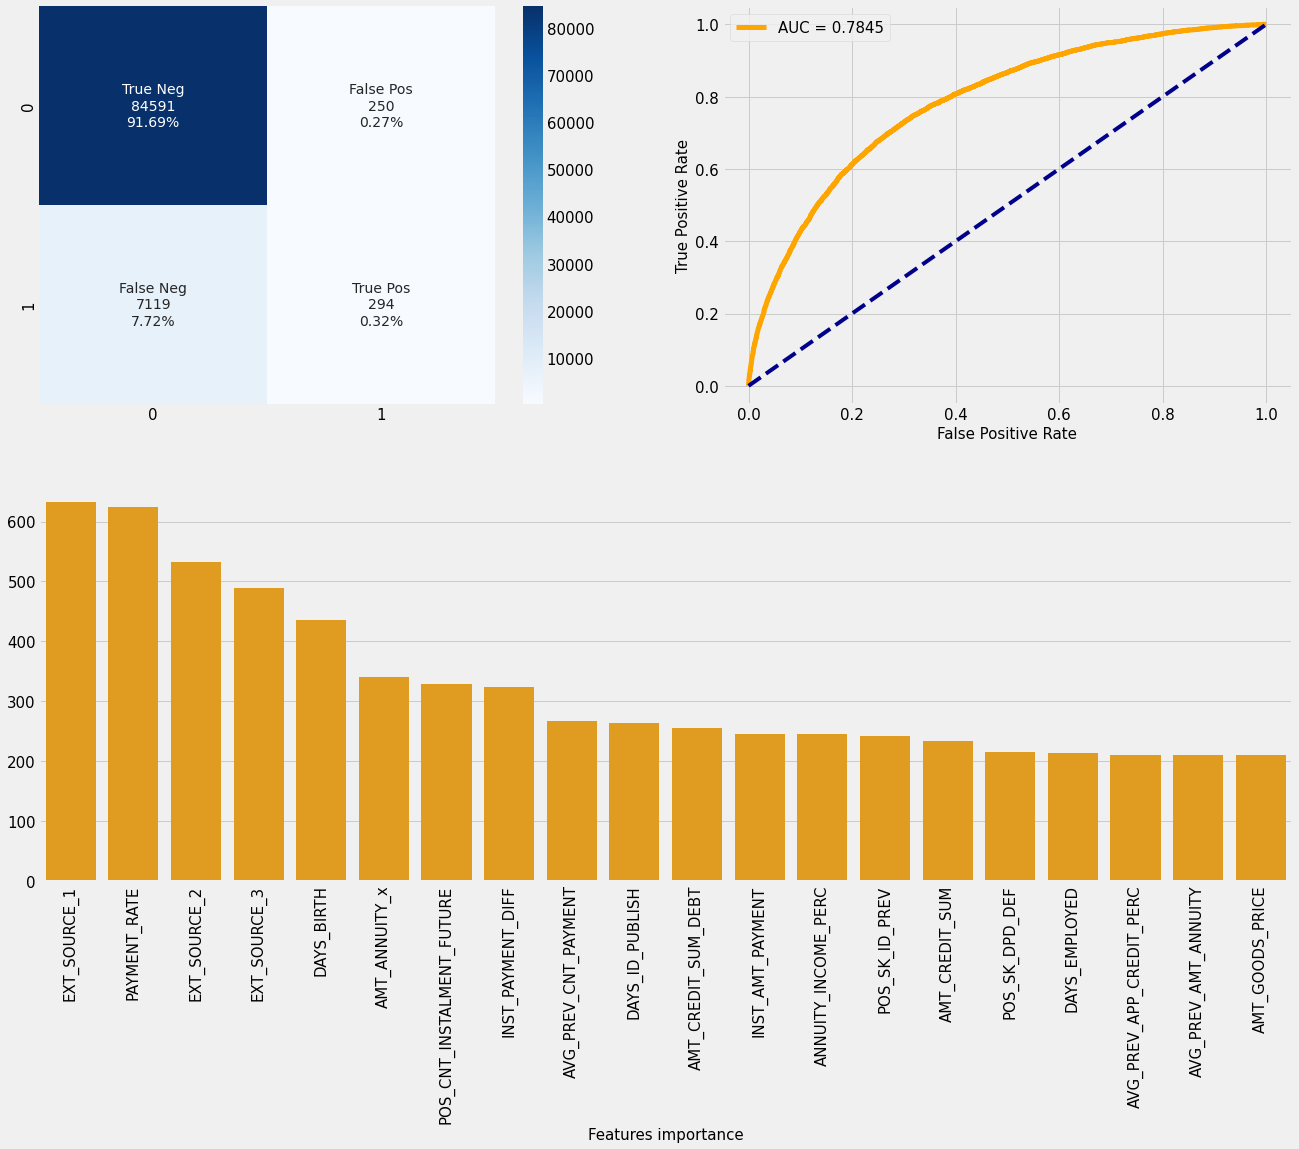

In [120]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [121]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.27%
False Neg: 7.72%


(0.0027099095974158303, 0.07716738569601318)

In [122]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['EXT_SOURCE_1', 632]
['PAYMENT_RATE', 624]
['EXT_SOURCE_2', 532]
['EXT_SOURCE_3', 489]
['DAYS_BIRTH', 435]
['AMT_ANNUITY_x', 341]
['POS_CNT_INSTALMENT_FUTURE', 329]
['INST_PAYMENT_DIFF', 324]
['AVG_PREV_CNT_PAYMENT', 267]
['DAYS_ID_PUBLISH', 263]
['AMT_CREDIT_SUM_DEBT', 255]
['INST_AMT_PAYMENT', 245]
['ANNUITY_INCOME_PERC', 245]
['POS_SK_ID_PREV', 242]
['AMT_CREDIT_SUM', 234]
['POS_SK_DPD_DEF', 216]
['DAYS_EMPLOYED', 214]
['AVG_PREV_APP_CREDIT_PERC', 211]
['AVG_PREV_AMT_ANNUITY', 210]
['AMT_GOODS_PRICE', 210]
['INST_DBD', 209]
['DAYS_REGISTRATION', 207]
['AMT_CREDIT', 197]
['DAYS_EMPLOYED_PERC', 193]
['AVG_PREV_DAYS_LAST_DUE_1ST_VERSION', 178]
['CC_BAL_CNT_DRAWINGS_ATM_CURRENT', 169]
['DAYS_CREDIT', 165]
['INST_SK_ID_PREV', 161]
['DAYS_LAST_PHONE_CHANGE', 160]
['REGION_POPULATION_RELATIVE', 151]
['AVG_PREV_NAME_CONTRACT_STATUS_Refused', 150]
['AVG_PREV_SELLERPLACE_AREA', 145]
['AMT_CREDIT_MAX_OVERDUE', 144]
['AVG_PREV_AMT_DOWN_PAYMENT', 139]
['DAYS_CREDIT_ENDDATE', 139]
['AVG_PREV_HOU

In [123]:
import streamlit as st

In [ ]:
st.

In [46]:
# Instanciation de l'algorithme
log_modeling_LGBM_rfecv = LGBMClassifier()

# Apprentissage à l'aide de la fonction fit sur le jeu d'entraînement
log_modeling_LGBM_rfecv.fit(X_train_selected, y_train)

LGBMClassifier()

In [50]:
# Métriques de log_model pour divers seuils
df_metrics_model_LGBM_rfecv = print_results_rfcev(log_modeling_LGBM_rfecv)
df_metrics_model_LGBM_rfecv.head(5)

ValueError: Number of features of the model must match the input. Model n_features_ is 234 and input n_features is 504

In [33]:
#matrice de confusion
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predBrut))

[[57974 26867]
 [ 2572  4841]]


In [31]:
#affichage
import numpy
print(numpy.unique(predBrut, return_counts = True))

(array([0., 1.]), array([60546, 31708], dtype=int64))


### Modélisation

Pour rappel, l'échantillon de travail n'est pas équilibré, avec environ 92% des clients classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement d crédit. Il est donc intéressant de travailler ce suréchantillonnage  en ajustant la distribution de classe de manière à avoir une répartion plus égalitaire.

In [24]:
#!pip install catboost
#!pip install lightgbm
#!pip install xgboost

### Import des différents algorithmes de regression

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Instanciation des différents algorithmes de regression

In [102]:
reg_LogisticRegression = LogisticRegression(C = 0.0001, max_iter=100)
reg_CatBoostClassifier = CatBoostClassifier()
reg_LGBMClassifier = LGBMClassifier()
reg_XGBClassifier = XGBClassifier()

### Choix des indicateurs d’évaluation

In [103]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

### Jeu de données d'apprentissage non équilibrées

#### Apprentissage à l'aide de la fonction fit

In [104]:
reg_LogisticRegression.fit(X_train, y_train)
reg_CatBoostClassifier.fit(X_train, y_train)
reg_LGBMClassifier.fit(X_train, y_train)
reg_XGBClassifier.fit(X_train, y_train)

Learning rate set to 0.102118
0:	learn: 0.5886801	total: 320ms	remaining: 5m 19s
1:	learn: 0.5122114	total: 528ms	remaining: 4m 23s
2:	learn: 0.4569588	total: 768ms	remaining: 4m 15s
3:	learn: 0.4122050	total: 1s	remaining: 4m 9s
4:	learn: 0.3779787	total: 1.18s	remaining: 3m 55s
5:	learn: 0.3517818	total: 1.37s	remaining: 3m 47s
6:	learn: 0.3328510	total: 1.52s	remaining: 3m 35s
7:	learn: 0.3171367	total: 1.68s	remaining: 3m 28s
8:	learn: 0.3041950	total: 2.53s	remaining: 4m 38s
9:	learn: 0.2938843	total: 2.67s	remaining: 4m 24s
10:	learn: 0.2856014	total: 2.88s	remaining: 4m 19s
11:	learn: 0.2799101	total: 3.04s	remaining: 4m 10s
12:	learn: 0.2746978	total: 3.24s	remaining: 4m 5s
13:	learn: 0.2707518	total: 3.41s	remaining: 4m
14:	learn: 0.2673699	total: 3.59s	remaining: 3m 55s
15:	learn: 0.2645839	total: 3.79s	remaining: 3m 53s
16:	learn: 0.2624643	total: 3.97s	remaining: 3m 49s
17:	learn: 0.2606956	total: 4.12s	remaining: 3m 44s
18:	learn: 0.2592796	total: 4.37s	remaining: 3m 45s
1

158:	learn: 0.2351391	total: 31.3s	remaining: 2m 45s
159:	learn: 0.2350806	total: 31.5s	remaining: 2m 45s
160:	learn: 0.2350251	total: 31.6s	remaining: 2m 44s
161:	learn: 0.2349764	total: 31.8s	remaining: 2m 44s
162:	learn: 0.2349190	total: 31.9s	remaining: 2m 43s
163:	learn: 0.2348560	total: 32.1s	remaining: 2m 43s
164:	learn: 0.2348041	total: 32.2s	remaining: 2m 43s
165:	learn: 0.2347388	total: 32.4s	remaining: 2m 42s
166:	learn: 0.2346631	total: 32.5s	remaining: 2m 42s
167:	learn: 0.2346018	total: 32.7s	remaining: 2m 41s
168:	learn: 0.2345049	total: 32.9s	remaining: 2m 41s
169:	learn: 0.2344351	total: 33s	remaining: 2m 41s
170:	learn: 0.2343571	total: 33.2s	remaining: 2m 41s
171:	learn: 0.2342862	total: 33.4s	remaining: 2m 40s
172:	learn: 0.2342275	total: 33.5s	remaining: 2m 40s
173:	learn: 0.2341898	total: 33.7s	remaining: 2m 39s
174:	learn: 0.2341214	total: 33.8s	remaining: 2m 39s
175:	learn: 0.2340516	total: 34s	remaining: 2m 38s
176:	learn: 0.2339961	total: 34.1s	remaining: 2m 3

315:	learn: 0.2267737	total: 58.6s	remaining: 2m 6s
316:	learn: 0.2267370	total: 58.8s	remaining: 2m 6s
317:	learn: 0.2266898	total: 59s	remaining: 2m 6s
318:	learn: 0.2266234	total: 59.2s	remaining: 2m 6s
319:	learn: 0.2265867	total: 59.3s	remaining: 2m 6s
320:	learn: 0.2265290	total: 59.5s	remaining: 2m 5s
321:	learn: 0.2264756	total: 59.7s	remaining: 2m 5s
322:	learn: 0.2264309	total: 59.9s	remaining: 2m 5s
323:	learn: 0.2263741	total: 1m	remaining: 2m 5s
324:	learn: 0.2263333	total: 1m	remaining: 2m 5s
325:	learn: 0.2262706	total: 1m	remaining: 2m 4s
326:	learn: 0.2262281	total: 1m	remaining: 2m 4s
327:	learn: 0.2261703	total: 1m	remaining: 2m 4s
328:	learn: 0.2261250	total: 1m	remaining: 2m 4s
329:	learn: 0.2260831	total: 1m 1s	remaining: 2m 3s
330:	learn: 0.2260224	total: 1m 1s	remaining: 2m 3s
331:	learn: 0.2259739	total: 1m 1s	remaining: 2m 3s
332:	learn: 0.2259269	total: 1m 1s	remaining: 2m 3s
333:	learn: 0.2258840	total: 1m 1s	remaining: 2m 3s
334:	learn: 0.2258509	total: 1m 

471:	learn: 0.2199910	total: 1m 24s	remaining: 1m 35s
472:	learn: 0.2199378	total: 1m 25s	remaining: 1m 34s
473:	learn: 0.2199145	total: 1m 25s	remaining: 1m 34s
474:	learn: 0.2198683	total: 1m 25s	remaining: 1m 34s
475:	learn: 0.2198277	total: 1m 25s	remaining: 1m 34s
476:	learn: 0.2197952	total: 1m 25s	remaining: 1m 34s
477:	learn: 0.2197940	total: 1m 25s	remaining: 1m 33s
478:	learn: 0.2197496	total: 1m 26s	remaining: 1m 33s
479:	learn: 0.2197152	total: 1m 26s	remaining: 1m 33s
480:	learn: 0.2196651	total: 1m 26s	remaining: 1m 33s
481:	learn: 0.2196069	total: 1m 26s	remaining: 1m 33s
482:	learn: 0.2195421	total: 1m 26s	remaining: 1m 32s
483:	learn: 0.2195106	total: 1m 26s	remaining: 1m 32s
484:	learn: 0.2194802	total: 1m 27s	remaining: 1m 32s
485:	learn: 0.2194495	total: 1m 27s	remaining: 1m 32s
486:	learn: 0.2194114	total: 1m 27s	remaining: 1m 32s
487:	learn: 0.2193606	total: 1m 27s	remaining: 1m 31s
488:	learn: 0.2193067	total: 1m 27s	remaining: 1m 31s
489:	learn: 0.2192853	total:

624:	learn: 0.2140491	total: 1m 50s	remaining: 1m 6s
625:	learn: 0.2140100	total: 1m 50s	remaining: 1m 6s
626:	learn: 0.2139732	total: 1m 51s	remaining: 1m 6s
627:	learn: 0.2139372	total: 1m 51s	remaining: 1m 5s
628:	learn: 0.2138883	total: 1m 51s	remaining: 1m 5s
629:	learn: 0.2138276	total: 1m 51s	remaining: 1m 5s
630:	learn: 0.2137932	total: 1m 51s	remaining: 1m 5s
631:	learn: 0.2137312	total: 1m 51s	remaining: 1m 5s
632:	learn: 0.2137034	total: 1m 51s	remaining: 1m 4s
633:	learn: 0.2136689	total: 1m 52s	remaining: 1m 4s
634:	learn: 0.2136243	total: 1m 52s	remaining: 1m 4s
635:	learn: 0.2135772	total: 1m 52s	remaining: 1m 4s
636:	learn: 0.2135258	total: 1m 52s	remaining: 1m 4s
637:	learn: 0.2134940	total: 1m 52s	remaining: 1m 4s
638:	learn: 0.2134530	total: 1m 52s	remaining: 1m 3s
639:	learn: 0.2134258	total: 1m 53s	remaining: 1m 3s
640:	learn: 0.2133967	total: 1m 53s	remaining: 1m 3s
641:	learn: 0.2133751	total: 1m 53s	remaining: 1m 3s
642:	learn: 0.2133230	total: 1m 53s	remaining:

781:	learn: 0.2086621	total: 2m 14s	remaining: 37.5s
782:	learn: 0.2086211	total: 2m 14s	remaining: 37.3s
783:	learn: 0.2085886	total: 2m 14s	remaining: 37.1s
784:	learn: 0.2085487	total: 2m 14s	remaining: 36.9s
785:	learn: 0.2085052	total: 2m 15s	remaining: 36.8s
786:	learn: 0.2084761	total: 2m 15s	remaining: 36.6s
787:	learn: 0.2084419	total: 2m 15s	remaining: 36.4s
788:	learn: 0.2083995	total: 2m 15s	remaining: 36.2s
789:	learn: 0.2083617	total: 2m 15s	remaining: 36.1s
790:	learn: 0.2083362	total: 2m 15s	remaining: 35.9s
791:	learn: 0.2083025	total: 2m 15s	remaining: 35.7s
792:	learn: 0.2082651	total: 2m 16s	remaining: 35.5s
793:	learn: 0.2082474	total: 2m 16s	remaining: 35.3s
794:	learn: 0.2081968	total: 2m 16s	remaining: 35.2s
795:	learn: 0.2081534	total: 2m 16s	remaining: 35s
796:	learn: 0.2081269	total: 2m 16s	remaining: 34.9s
797:	learn: 0.2081012	total: 2m 16s	remaining: 34.7s
798:	learn: 0.2080720	total: 2m 17s	remaining: 34.5s
799:	learn: 0.2080167	total: 2m 17s	remaining: 3

937:	learn: 0.2033039	total: 2m 39s	remaining: 10.5s
938:	learn: 0.2032807	total: 2m 39s	remaining: 10.3s
939:	learn: 0.2032472	total: 2m 39s	remaining: 10.2s
940:	learn: 0.2031991	total: 2m 39s	remaining: 10s
941:	learn: 0.2031683	total: 2m 39s	remaining: 9.83s
942:	learn: 0.2031234	total: 2m 39s	remaining: 9.66s
943:	learn: 0.2030959	total: 2m 40s	remaining: 9.49s
944:	learn: 0.2030671	total: 2m 40s	remaining: 9.32s
945:	learn: 0.2030401	total: 2m 40s	remaining: 9.15s
946:	learn: 0.2030043	total: 2m 40s	remaining: 8.98s
947:	learn: 0.2029663	total: 2m 40s	remaining: 8.81s
948:	learn: 0.2029379	total: 2m 40s	remaining: 8.64s
949:	learn: 0.2029243	total: 2m 40s	remaining: 8.47s
950:	learn: 0.2028896	total: 2m 41s	remaining: 8.3s
951:	learn: 0.2028549	total: 2m 41s	remaining: 8.13s
952:	learn: 0.2028223	total: 2m 41s	remaining: 7.96s
953:	learn: 0.2027836	total: 2m 41s	remaining: 7.8s
954:	learn: 0.2027612	total: 2m 41s	remaining: 7.63s
955:	learn: 0.2027419	total: 2m 41s	remaining: 7.4

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Prédictions et évaluation sur de la performance

In [105]:
# Sauvegarde des performances correspondantes
import math

dict_modeles = {
    'LogisticRegression': reg_LogisticRegression,
    'CatBoostClassifier': reg_CatBoostClassifier,
    'LGBMClassifier': reg_LGBMClassifier,
    'XGBClassifier': reg_XGBClassifier
}

nom_modeles = ['LogisticRegression', 'CatBoostClassifier','LGBMClassifier', 'XGBClassifier']
liste_modeles = [dict_modeles['LogisticRegression'],
                 dict_modeles['CatBoostClassifier'],
                 dict_modeles['LGBMClassifier'],
                 dict_modeles['XGBClassifier']]

comparaison_performance = pd.DataFrame(index = nom_modeles, columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_performance.loc[nom_modele, 'AUC'] = roc_auc_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Accuracy'] = accuracy_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Precision'] = precision_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Recall'] = recall_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'F1'] = f1_score(y_test, modele.predict(X_test))

In [106]:
comparaison_performance.sort_values(by = 'AUC')

,AUC,Accuracy,Precision,Recall,F1
LogisticRegression,0.5,0.919331,0.0,0.0,0.0
LGBMClassifier,0.515131,0.919992,0.572447,0.032384,0.0613
CatBoostClassifier,0.52196,0.919927,0.542243,0.047433,0.087236
XGBClassifier,0.525996,0.919233,0.494761,0.057108,0.102397


### Jeu de données d'apprentissage équilibrées

#### Oversampling Data Using SMOTE

In [107]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17383 
Label 0, Before using SMOTE: 197871 


In [108]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

Wall time: 3min 58s


In [109]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197871
Label 0, After using SMOTE: 197871


#### Apprentissage à l'aide de la fonction fit

In [110]:
reg_LogisticRegression.fit(X_train_res, y_train_res)
reg_CatBoostClassifier.fit(X_train_res, y_train_res)
reg_LGBMClassifier.fit(X_train_res, y_train_res)
reg_XGBClassifier.fit(X_train_res, y_train_res)

Learning rate set to 0.132443
0:	learn: 0.6016708	total: 1.17s	remaining: 19m 27s
1:	learn: 0.5253056	total: 1.65s	remaining: 13m 44s
2:	learn: 0.4989168	total: 2.15s	remaining: 11m 55s
3:	learn: 0.4587227	total: 2.71s	remaining: 11m 15s
4:	learn: 0.4420170	total: 3.13s	remaining: 10m 22s
5:	learn: 0.4141467	total: 3.65s	remaining: 10m 4s
6:	learn: 0.3976488	total: 4.09s	remaining: 9m 40s
7:	learn: 0.3730635	total: 4.54s	remaining: 9m 22s
8:	learn: 0.3406200	total: 4.92s	remaining: 9m 2s
9:	learn: 0.3323747	total: 5.31s	remaining: 8m 46s
10:	learn: 0.3098638	total: 5.83s	remaining: 8m 44s
11:	learn: 0.2962078	total: 6.31s	remaining: 8m 39s
12:	learn: 0.2875719	total: 6.97s	remaining: 8m 48s
13:	learn: 0.2711544	total: 7.44s	remaining: 8m 44s
14:	learn: 0.2652640	total: 7.87s	remaining: 8m 36s
15:	learn: 0.2603696	total: 8.35s	remaining: 8m 33s
16:	learn: 0.2510474	total: 8.71s	remaining: 8m 23s
17:	learn: 0.2453569	total: 9.11s	remaining: 8m 17s
18:	learn: 0.2343361	total: 9.61s	remain

157:	learn: 0.1360773	total: 1m 13s	remaining: 6m 34s
158:	learn: 0.1360032	total: 1m 14s	remaining: 6m 33s
159:	learn: 0.1359667	total: 1m 14s	remaining: 6m 32s
160:	learn: 0.1359137	total: 1m 15s	remaining: 6m 31s
161:	learn: 0.1358577	total: 1m 15s	remaining: 6m 30s
162:	learn: 0.1357012	total: 1m 15s	remaining: 6m 29s
163:	learn: 0.1356201	total: 1m 16s	remaining: 6m 29s
164:	learn: 0.1355699	total: 1m 16s	remaining: 6m 28s
165:	learn: 0.1355378	total: 1m 17s	remaining: 6m 27s
166:	learn: 0.1354878	total: 1m 17s	remaining: 6m 26s
167:	learn: 0.1354362	total: 1m 17s	remaining: 6m 25s
168:	learn: 0.1353975	total: 1m 18s	remaining: 6m 24s
169:	learn: 0.1353739	total: 1m 18s	remaining: 6m 23s
170:	learn: 0.1353176	total: 1m 19s	remaining: 6m 23s
171:	learn: 0.1352785	total: 1m 19s	remaining: 6m 22s
172:	learn: 0.1352367	total: 1m 19s	remaining: 6m 21s
173:	learn: 0.1351714	total: 1m 20s	remaining: 6m 20s
174:	learn: 0.1351359	total: 1m 20s	remaining: 6m 19s
175:	learn: 0.1350963	total:

311:	learn: 0.1279435	total: 2m 14s	remaining: 4m 57s
312:	learn: 0.1279110	total: 2m 15s	remaining: 4m 57s
313:	learn: 0.1278765	total: 2m 15s	remaining: 4m 56s
314:	learn: 0.1278303	total: 2m 16s	remaining: 4m 56s
315:	learn: 0.1277956	total: 2m 16s	remaining: 4m 55s
316:	learn: 0.1277616	total: 2m 16s	remaining: 4m 55s
317:	learn: 0.1277248	total: 2m 17s	remaining: 4m 54s
318:	learn: 0.1276897	total: 2m 17s	remaining: 4m 54s
319:	learn: 0.1276508	total: 2m 18s	remaining: 4m 53s
320:	learn: 0.1276155	total: 2m 18s	remaining: 4m 53s
321:	learn: 0.1275712	total: 2m 19s	remaining: 4m 53s
322:	learn: 0.1275326	total: 2m 20s	remaining: 4m 53s
323:	learn: 0.1274962	total: 2m 20s	remaining: 4m 53s
324:	learn: 0.1274641	total: 2m 20s	remaining: 4m 52s
325:	learn: 0.1274384	total: 2m 21s	remaining: 4m 52s
326:	learn: 0.1274033	total: 2m 21s	remaining: 4m 51s
327:	learn: 0.1273676	total: 2m 22s	remaining: 4m 51s
328:	learn: 0.1273304	total: 2m 22s	remaining: 4m 50s
329:	learn: 0.1273057	total:

464:	learn: 0.1231868	total: 3m 15s	remaining: 3m 44s
465:	learn: 0.1231660	total: 3m 15s	remaining: 3m 44s
466:	learn: 0.1231509	total: 3m 15s	remaining: 3m 43s
467:	learn: 0.1231245	total: 3m 16s	remaining: 3m 42s
468:	learn: 0.1230970	total: 3m 16s	remaining: 3m 42s
469:	learn: 0.1230815	total: 3m 16s	remaining: 3m 41s
470:	learn: 0.1230512	total: 3m 17s	remaining: 3m 41s
471:	learn: 0.1230237	total: 3m 17s	remaining: 3m 40s
472:	learn: 0.1229880	total: 3m 17s	remaining: 3m 40s
473:	learn: 0.1229595	total: 3m 18s	remaining: 3m 39s
474:	learn: 0.1229393	total: 3m 18s	remaining: 3m 39s
475:	learn: 0.1229106	total: 3m 18s	remaining: 3m 38s
476:	learn: 0.1228764	total: 3m 19s	remaining: 3m 38s
477:	learn: 0.1228319	total: 3m 19s	remaining: 3m 38s
478:	learn: 0.1228110	total: 3m 19s	remaining: 3m 37s
479:	learn: 0.1227775	total: 3m 20s	remaining: 3m 37s
480:	learn: 0.1227438	total: 3m 20s	remaining: 3m 36s
481:	learn: 0.1227110	total: 3m 21s	remaining: 3m 36s
482:	learn: 0.1226637	total:

617:	learn: 0.1188600	total: 4m 13s	remaining: 2m 36s
618:	learn: 0.1188456	total: 4m 13s	remaining: 2m 35s
619:	learn: 0.1188208	total: 4m 13s	remaining: 2m 35s
620:	learn: 0.1188022	total: 4m 14s	remaining: 2m 35s
621:	learn: 0.1187694	total: 4m 14s	remaining: 2m 34s
622:	learn: 0.1187447	total: 4m 14s	remaining: 2m 34s
623:	learn: 0.1187103	total: 4m 15s	remaining: 2m 33s
624:	learn: 0.1186926	total: 4m 15s	remaining: 2m 33s
625:	learn: 0.1186660	total: 4m 16s	remaining: 2m 32s
626:	learn: 0.1186347	total: 4m 16s	remaining: 2m 32s
627:	learn: 0.1186084	total: 4m 16s	remaining: 2m 32s
628:	learn: 0.1185770	total: 4m 17s	remaining: 2m 31s
629:	learn: 0.1185403	total: 4m 17s	remaining: 2m 31s
630:	learn: 0.1185180	total: 4m 18s	remaining: 2m 30s
631:	learn: 0.1184893	total: 4m 18s	remaining: 2m 30s
632:	learn: 0.1184698	total: 4m 19s	remaining: 2m 30s
633:	learn: 0.1184335	total: 4m 19s	remaining: 2m 29s
634:	learn: 0.1184091	total: 4m 19s	remaining: 2m 29s
635:	learn: 0.1183895	total:

770:	learn: 0.1151918	total: 5m 12s	remaining: 1m 32s
771:	learn: 0.1151805	total: 5m 13s	remaining: 1m 32s
772:	learn: 0.1151592	total: 5m 13s	remaining: 1m 32s
773:	learn: 0.1151444	total: 5m 13s	remaining: 1m 31s
774:	learn: 0.1151177	total: 5m 14s	remaining: 1m 31s
775:	learn: 0.1151008	total: 5m 14s	remaining: 1m 30s
776:	learn: 0.1150817	total: 5m 14s	remaining: 1m 30s
777:	learn: 0.1150586	total: 5m 15s	remaining: 1m 29s
778:	learn: 0.1150330	total: 5m 15s	remaining: 1m 29s
779:	learn: 0.1150156	total: 5m 16s	remaining: 1m 29s
780:	learn: 0.1149924	total: 5m 16s	remaining: 1m 28s
781:	learn: 0.1149723	total: 5m 17s	remaining: 1m 28s
782:	learn: 0.1149426	total: 5m 17s	remaining: 1m 27s
783:	learn: 0.1149219	total: 5m 17s	remaining: 1m 27s
784:	learn: 0.1148927	total: 5m 18s	remaining: 1m 27s
785:	learn: 0.1148750	total: 5m 18s	remaining: 1m 26s
786:	learn: 0.1148574	total: 5m 19s	remaining: 1m 26s
787:	learn: 0.1148348	total: 5m 20s	remaining: 1m 26s
788:	learn: 0.1148250	total:

925:	learn: 0.1116464	total: 6m 17s	remaining: 30.2s
926:	learn: 0.1116288	total: 6m 17s	remaining: 29.8s
927:	learn: 0.1115939	total: 6m 18s	remaining: 29.4s
928:	learn: 0.1115680	total: 6m 18s	remaining: 28.9s
929:	learn: 0.1115511	total: 6m 19s	remaining: 28.5s
930:	learn: 0.1115232	total: 6m 19s	remaining: 28.1s
931:	learn: 0.1115115	total: 6m 19s	remaining: 27.7s
932:	learn: 0.1114869	total: 6m 20s	remaining: 27.3s
933:	learn: 0.1114693	total: 6m 20s	remaining: 26.9s
934:	learn: 0.1114510	total: 6m 20s	remaining: 26.5s
935:	learn: 0.1114344	total: 6m 21s	remaining: 26.1s
936:	learn: 0.1114055	total: 6m 21s	remaining: 25.7s
937:	learn: 0.1113851	total: 6m 22s	remaining: 25.3s
938:	learn: 0.1113666	total: 6m 22s	remaining: 24.8s
939:	learn: 0.1113397	total: 6m 22s	remaining: 24.4s
940:	learn: 0.1113204	total: 6m 23s	remaining: 24s
941:	learn: 0.1113117	total: 6m 23s	remaining: 23.6s
942:	learn: 0.1112952	total: 6m 23s	remaining: 23.2s
943:	learn: 0.1112640	total: 6m 24s	remaining: 2

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Prédictions et évaluation sur de la performance

In [111]:
# Sauvegarde des performances correspondantes
import math

dict_modeles = {
    'LogisticRegression': reg_LogisticRegression,
    'CatBoostClassifier': reg_CatBoostClassifier,
    'LGBMClassifier': reg_LGBMClassifier,
    'XGBClassifier': reg_XGBClassifier
}

nom_modeles = ['LogisticRegression', 'CatBoostClassifier','LGBMClassifier', 'XGBClassifier']
liste_modeles = [dict_modeles['LogisticRegression'],
                 dict_modeles['CatBoostClassifier'],
                 dict_modeles['LGBMClassifier'],
                 dict_modeles['XGBClassifier']]

comparaison_performance = pd.DataFrame(index = nom_modeles, columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_performance.loc[nom_modele, 'AUC'] = roc_auc_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Accuracy'] = accuracy_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Precision'] = precision_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Recall'] = recall_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'F1'] = f1_score(y_test, modele.predict(X_test))

In [112]:
comparaison_performance.sort_values(by = 'AUC')

,AUC,Accuracy,Precision,Recall,F1
LGBMClassifier,0.511006,0.919396,0.508523,0.024053,0.045933
CatBoostClassifier,0.522632,0.919471,0.50899,0.049449,0.090141
XGBClassifier,0.525582,0.918247,0.447589,0.057377,0.101715
LogisticRegression,0.66034,0.674905,0.148977,0.642972,0.241905


### Apprentissage à l'aide de la fonction fit sur le jeu de données d'apprentissage

In [42]:
reg_LogisticRegression.fit(X_train_res, y_train_res)
reg_CatBoostClassifier.fit(X_train_res, y_train_res)
reg_LGBMClassifier.fit(X_train_res, y_train_res)
reg_XGBClassifier.fit(X_train_res, y_train_res)

Learning rate set to 0.132443
0:	learn: 0.6016708	total: 695ms	remaining: 11m 34s
1:	learn: 0.5253056	total: 1.18s	remaining: 9m 47s
2:	learn: 0.4989168	total: 1.61s	remaining: 8m 56s
3:	learn: 0.4587227	total: 2.14s	remaining: 8m 52s
4:	learn: 0.4420170	total: 2.54s	remaining: 8m 25s
5:	learn: 0.4141467	total: 2.96s	remaining: 8m 11s
6:	learn: 0.3976488	total: 3.39s	remaining: 8m
7:	learn: 0.3730635	total: 3.8s	remaining: 7m 51s
8:	learn: 0.3406200	total: 4.16s	remaining: 7m 37s
9:	learn: 0.3323747	total: 4.54s	remaining: 7m 29s
10:	learn: 0.3098638	total: 5.02s	remaining: 7m 31s
11:	learn: 0.2962078	total: 5.53s	remaining: 7m 34s
12:	learn: 0.2875719	total: 5.96s	remaining: 7m 32s
13:	learn: 0.2711544	total: 6.35s	remaining: 7m 26s
14:	learn: 0.2652640	total: 6.71s	remaining: 7m 20s
15:	learn: 0.2603696	total: 7.11s	remaining: 7m 17s
16:	learn: 0.2510474	total: 7.46s	remaining: 7m 11s
17:	learn: 0.2453569	total: 7.83s	remaining: 7m 6s
18:	learn: 0.2343361	total: 8.24s	remaining: 7m 5

158:	learn: 0.1360032	total: 1m 9s	remaining: 6m 9s
159:	learn: 0.1359667	total: 1m 10s	remaining: 6m 8s
160:	learn: 0.1359137	total: 1m 10s	remaining: 6m 7s
161:	learn: 0.1358577	total: 1m 10s	remaining: 6m 6s
162:	learn: 0.1357012	total: 1m 11s	remaining: 6m 6s
163:	learn: 0.1356201	total: 1m 11s	remaining: 6m 6s
164:	learn: 0.1355699	total: 1m 12s	remaining: 6m 6s
165:	learn: 0.1355378	total: 1m 12s	remaining: 6m 4s
166:	learn: 0.1354878	total: 1m 13s	remaining: 6m 4s
167:	learn: 0.1354362	total: 1m 13s	remaining: 6m 3s
168:	learn: 0.1353975	total: 1m 13s	remaining: 6m 3s
169:	learn: 0.1353739	total: 1m 14s	remaining: 6m 2s
170:	learn: 0.1353176	total: 1m 14s	remaining: 6m 2s
171:	learn: 0.1352785	total: 1m 15s	remaining: 6m 1s
172:	learn: 0.1352367	total: 1m 15s	remaining: 6m
173:	learn: 0.1351714	total: 1m 15s	remaining: 6m
174:	learn: 0.1351359	total: 1m 16s	remaining: 5m 59s
175:	learn: 0.1350963	total: 1m 16s	remaining: 5m 58s
176:	learn: 0.1350493	total: 1m 17s	remaining: 5m 5

311:	learn: 0.1279435	total: 2m 18s	remaining: 5m 4s
312:	learn: 0.1279110	total: 2m 18s	remaining: 5m 4s
313:	learn: 0.1278765	total: 2m 18s	remaining: 5m 3s
314:	learn: 0.1278303	total: 2m 19s	remaining: 5m 3s
315:	learn: 0.1277956	total: 2m 19s	remaining: 5m 2s
316:	learn: 0.1277616	total: 2m 20s	remaining: 5m 2s
317:	learn: 0.1277248	total: 2m 20s	remaining: 5m 1s
318:	learn: 0.1276897	total: 2m 21s	remaining: 5m 1s
319:	learn: 0.1276508	total: 2m 21s	remaining: 5m
320:	learn: 0.1276155	total: 2m 21s	remaining: 5m
321:	learn: 0.1275712	total: 2m 22s	remaining: 4m 59s
322:	learn: 0.1275326	total: 2m 22s	remaining: 4m 59s
323:	learn: 0.1274962	total: 2m 23s	remaining: 4m 59s
324:	learn: 0.1274641	total: 2m 23s	remaining: 4m 59s
325:	learn: 0.1274384	total: 2m 24s	remaining: 4m 58s
326:	learn: 0.1274033	total: 2m 24s	remaining: 4m 58s
327:	learn: 0.1273676	total: 2m 25s	remaining: 4m 57s
328:	learn: 0.1273304	total: 2m 25s	remaining: 4m 57s
329:	learn: 0.1273057	total: 2m 26s	remainin

465:	learn: 0.1231660	total: 3m 21s	remaining: 3m 51s
466:	learn: 0.1231509	total: 3m 22s	remaining: 3m 50s
467:	learn: 0.1231245	total: 3m 22s	remaining: 3m 50s
468:	learn: 0.1230970	total: 3m 23s	remaining: 3m 49s
469:	learn: 0.1230815	total: 3m 23s	remaining: 3m 49s
470:	learn: 0.1230512	total: 3m 23s	remaining: 3m 48s
471:	learn: 0.1230237	total: 3m 24s	remaining: 3m 48s
472:	learn: 0.1229880	total: 3m 24s	remaining: 3m 48s
473:	learn: 0.1229595	total: 3m 25s	remaining: 3m 47s
474:	learn: 0.1229393	total: 3m 25s	remaining: 3m 47s
475:	learn: 0.1229106	total: 3m 26s	remaining: 3m 46s
476:	learn: 0.1228764	total: 3m 26s	remaining: 3m 46s
477:	learn: 0.1228319	total: 3m 27s	remaining: 3m 46s
478:	learn: 0.1228110	total: 3m 27s	remaining: 3m 45s
479:	learn: 0.1227775	total: 3m 27s	remaining: 3m 45s
480:	learn: 0.1227438	total: 3m 28s	remaining: 3m 44s
481:	learn: 0.1227110	total: 3m 28s	remaining: 3m 44s
482:	learn: 0.1226637	total: 3m 29s	remaining: 3m 44s
483:	learn: 0.1226300	total:

618:	learn: 0.1188456	total: 4m 27s	remaining: 2m 44s
619:	learn: 0.1188208	total: 4m 28s	remaining: 2m 44s
620:	learn: 0.1188022	total: 4m 29s	remaining: 2m 44s
621:	learn: 0.1187694	total: 4m 29s	remaining: 2m 43s
622:	learn: 0.1187447	total: 4m 30s	remaining: 2m 43s
623:	learn: 0.1187103	total: 4m 30s	remaining: 2m 43s
624:	learn: 0.1186926	total: 4m 31s	remaining: 2m 42s
625:	learn: 0.1186660	total: 4m 31s	remaining: 2m 42s
626:	learn: 0.1186347	total: 4m 31s	remaining: 2m 41s
627:	learn: 0.1186084	total: 4m 32s	remaining: 2m 41s
628:	learn: 0.1185770	total: 4m 32s	remaining: 2m 40s
629:	learn: 0.1185403	total: 4m 33s	remaining: 2m 40s
630:	learn: 0.1185180	total: 4m 33s	remaining: 2m 40s
631:	learn: 0.1184893	total: 4m 34s	remaining: 2m 39s
632:	learn: 0.1184698	total: 4m 34s	remaining: 2m 39s
633:	learn: 0.1184335	total: 4m 35s	remaining: 2m 38s
634:	learn: 0.1184091	total: 4m 36s	remaining: 2m 38s
635:	learn: 0.1183895	total: 4m 36s	remaining: 2m 38s
636:	learn: 0.1183744	total:

771:	learn: 0.1151805	total: 5m 30s	remaining: 1m 37s
772:	learn: 0.1151592	total: 5m 31s	remaining: 1m 37s
773:	learn: 0.1151444	total: 5m 31s	remaining: 1m 36s
774:	learn: 0.1151177	total: 5m 31s	remaining: 1m 36s
775:	learn: 0.1151008	total: 5m 32s	remaining: 1m 35s
776:	learn: 0.1150817	total: 5m 32s	remaining: 1m 35s
777:	learn: 0.1150586	total: 5m 33s	remaining: 1m 35s
778:	learn: 0.1150330	total: 5m 33s	remaining: 1m 34s
779:	learn: 0.1150156	total: 5m 34s	remaining: 1m 34s
780:	learn: 0.1149924	total: 5m 34s	remaining: 1m 33s
781:	learn: 0.1149723	total: 5m 34s	remaining: 1m 33s
782:	learn: 0.1149426	total: 5m 35s	remaining: 1m 32s
783:	learn: 0.1149219	total: 5m 35s	remaining: 1m 32s
784:	learn: 0.1148927	total: 5m 36s	remaining: 1m 32s
785:	learn: 0.1148750	total: 5m 36s	remaining: 1m 31s
786:	learn: 0.1148574	total: 5m 36s	remaining: 1m 31s
787:	learn: 0.1148348	total: 5m 37s	remaining: 1m 30s
788:	learn: 0.1148250	total: 5m 37s	remaining: 1m 30s
789:	learn: 0.1147938	total:

926:	learn: 0.1116288	total: 6m 35s	remaining: 31.2s
927:	learn: 0.1115939	total: 6m 36s	remaining: 30.7s
928:	learn: 0.1115680	total: 6m 36s	remaining: 30.3s
929:	learn: 0.1115511	total: 6m 36s	remaining: 29.9s
930:	learn: 0.1115232	total: 6m 37s	remaining: 29.4s
931:	learn: 0.1115115	total: 6m 37s	remaining: 29s
932:	learn: 0.1114869	total: 6m 37s	remaining: 28.6s
933:	learn: 0.1114693	total: 6m 38s	remaining: 28.1s
934:	learn: 0.1114510	total: 6m 38s	remaining: 27.7s
935:	learn: 0.1114344	total: 6m 38s	remaining: 27.3s
936:	learn: 0.1114055	total: 6m 39s	remaining: 26.8s
937:	learn: 0.1113851	total: 6m 39s	remaining: 26.4s
938:	learn: 0.1113666	total: 6m 40s	remaining: 26s
939:	learn: 0.1113397	total: 6m 40s	remaining: 25.6s
940:	learn: 0.1113204	total: 6m 40s	remaining: 25.1s
941:	learn: 0.1113117	total: 6m 41s	remaining: 24.7s
942:	learn: 0.1112952	total: 6m 41s	remaining: 24.3s
943:	learn: 0.1112640	total: 6m 41s	remaining: 23.8s
944:	learn: 0.1112344	total: 6m 42s	remaining: 23.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Prédictions et évaluation sur de la performance des différents algorithmes sur le jeu de données test

In [48]:
# Sauvegarde des performances correspondantes
import math

dict_modeles = {
    'LogisticRegression': reg_LogisticRegression,
    'CatBoostClassifier': reg_CatBoostClassifier,
    'LGBMClassifier': reg_LGBMClassifier,
    'XGBClassifier': reg_XGBClassifier
}

nom_modeles = ['LogisticRegression', 'CatBoostClassifier','LGBMClassifier', 'XGBClassifier']
liste_modeles = [dict_modeles['LogisticRegression'],
                 dict_modeles['CatBoostClassifier'],
                 dict_modeles['LGBMClassifier'],
                 dict_modeles['XGBClassifier']]

comparaison_performance = pd.DataFrame(index = nom_modeles, columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_performance.loc[nom_modele, 'AUC'] = roc_auc_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Accuracy'] = accuracy_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Precision'] = precision_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Recall'] = recall_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'F1'] = f1_score(y_test, modele.predict(X_test))

In [49]:
comparaison_performance.sort_values(by = 'AUC')

,AUC,Accuracy,Precision,Recall,F1
LGBMClassifier,0.511006,0.919396,0.508523,0.024053,0.045933
CatBoostClassifier,0.522632,0.919471,0.50899,0.049449,0.090141
XGBClassifier,0.525582,0.918247,0.447589,0.057377,0.101715
LogisticRegression,0.66034,0.674905,0.148977,0.642972,0.241905


### Apprentissage à l'aide de la fonction fit sur le jeu de données d'apprentissage

In [42]:
reg_LogisticRegression.fit(X_train_res, y_train_res)
reg_CatBoostClassifier.fit(X_train_res, y_train_res)
reg_LGBMClassifier.fit(X_train_res, y_train_res)
reg_XGBClassifier.fit(X_train_res, y_train_res)

Learning rate set to 0.132443
0:	learn: 0.6016708	total: 695ms	remaining: 11m 34s
1:	learn: 0.5253056	total: 1.18s	remaining: 9m 47s
2:	learn: 0.4989168	total: 1.61s	remaining: 8m 56s
3:	learn: 0.4587227	total: 2.14s	remaining: 8m 52s
4:	learn: 0.4420170	total: 2.54s	remaining: 8m 25s
5:	learn: 0.4141467	total: 2.96s	remaining: 8m 11s
6:	learn: 0.3976488	total: 3.39s	remaining: 8m
7:	learn: 0.3730635	total: 3.8s	remaining: 7m 51s
8:	learn: 0.3406200	total: 4.16s	remaining: 7m 37s
9:	learn: 0.3323747	total: 4.54s	remaining: 7m 29s
10:	learn: 0.3098638	total: 5.02s	remaining: 7m 31s
11:	learn: 0.2962078	total: 5.53s	remaining: 7m 34s
12:	learn: 0.2875719	total: 5.96s	remaining: 7m 32s
13:	learn: 0.2711544	total: 6.35s	remaining: 7m 26s
14:	learn: 0.2652640	total: 6.71s	remaining: 7m 20s
15:	learn: 0.2603696	total: 7.11s	remaining: 7m 17s
16:	learn: 0.2510474	total: 7.46s	remaining: 7m 11s
17:	learn: 0.2453569	total: 7.83s	remaining: 7m 6s
18:	learn: 0.2343361	total: 8.24s	remaining: 7m 5

158:	learn: 0.1360032	total: 1m 9s	remaining: 6m 9s
159:	learn: 0.1359667	total: 1m 10s	remaining: 6m 8s
160:	learn: 0.1359137	total: 1m 10s	remaining: 6m 7s
161:	learn: 0.1358577	total: 1m 10s	remaining: 6m 6s
162:	learn: 0.1357012	total: 1m 11s	remaining: 6m 6s
163:	learn: 0.1356201	total: 1m 11s	remaining: 6m 6s
164:	learn: 0.1355699	total: 1m 12s	remaining: 6m 6s
165:	learn: 0.1355378	total: 1m 12s	remaining: 6m 4s
166:	learn: 0.1354878	total: 1m 13s	remaining: 6m 4s
167:	learn: 0.1354362	total: 1m 13s	remaining: 6m 3s
168:	learn: 0.1353975	total: 1m 13s	remaining: 6m 3s
169:	learn: 0.1353739	total: 1m 14s	remaining: 6m 2s
170:	learn: 0.1353176	total: 1m 14s	remaining: 6m 2s
171:	learn: 0.1352785	total: 1m 15s	remaining: 6m 1s
172:	learn: 0.1352367	total: 1m 15s	remaining: 6m
173:	learn: 0.1351714	total: 1m 15s	remaining: 6m
174:	learn: 0.1351359	total: 1m 16s	remaining: 5m 59s
175:	learn: 0.1350963	total: 1m 16s	remaining: 5m 58s
176:	learn: 0.1350493	total: 1m 17s	remaining: 5m 5

311:	learn: 0.1279435	total: 2m 18s	remaining: 5m 4s
312:	learn: 0.1279110	total: 2m 18s	remaining: 5m 4s
313:	learn: 0.1278765	total: 2m 18s	remaining: 5m 3s
314:	learn: 0.1278303	total: 2m 19s	remaining: 5m 3s
315:	learn: 0.1277956	total: 2m 19s	remaining: 5m 2s
316:	learn: 0.1277616	total: 2m 20s	remaining: 5m 2s
317:	learn: 0.1277248	total: 2m 20s	remaining: 5m 1s
318:	learn: 0.1276897	total: 2m 21s	remaining: 5m 1s
319:	learn: 0.1276508	total: 2m 21s	remaining: 5m
320:	learn: 0.1276155	total: 2m 21s	remaining: 5m
321:	learn: 0.1275712	total: 2m 22s	remaining: 4m 59s
322:	learn: 0.1275326	total: 2m 22s	remaining: 4m 59s
323:	learn: 0.1274962	total: 2m 23s	remaining: 4m 59s
324:	learn: 0.1274641	total: 2m 23s	remaining: 4m 59s
325:	learn: 0.1274384	total: 2m 24s	remaining: 4m 58s
326:	learn: 0.1274033	total: 2m 24s	remaining: 4m 58s
327:	learn: 0.1273676	total: 2m 25s	remaining: 4m 57s
328:	learn: 0.1273304	total: 2m 25s	remaining: 4m 57s
329:	learn: 0.1273057	total: 2m 26s	remainin

465:	learn: 0.1231660	total: 3m 21s	remaining: 3m 51s
466:	learn: 0.1231509	total: 3m 22s	remaining: 3m 50s
467:	learn: 0.1231245	total: 3m 22s	remaining: 3m 50s
468:	learn: 0.1230970	total: 3m 23s	remaining: 3m 49s
469:	learn: 0.1230815	total: 3m 23s	remaining: 3m 49s
470:	learn: 0.1230512	total: 3m 23s	remaining: 3m 48s
471:	learn: 0.1230237	total: 3m 24s	remaining: 3m 48s
472:	learn: 0.1229880	total: 3m 24s	remaining: 3m 48s
473:	learn: 0.1229595	total: 3m 25s	remaining: 3m 47s
474:	learn: 0.1229393	total: 3m 25s	remaining: 3m 47s
475:	learn: 0.1229106	total: 3m 26s	remaining: 3m 46s
476:	learn: 0.1228764	total: 3m 26s	remaining: 3m 46s
477:	learn: 0.1228319	total: 3m 27s	remaining: 3m 46s
478:	learn: 0.1228110	total: 3m 27s	remaining: 3m 45s
479:	learn: 0.1227775	total: 3m 27s	remaining: 3m 45s
480:	learn: 0.1227438	total: 3m 28s	remaining: 3m 44s
481:	learn: 0.1227110	total: 3m 28s	remaining: 3m 44s
482:	learn: 0.1226637	total: 3m 29s	remaining: 3m 44s
483:	learn: 0.1226300	total:

618:	learn: 0.1188456	total: 4m 27s	remaining: 2m 44s
619:	learn: 0.1188208	total: 4m 28s	remaining: 2m 44s
620:	learn: 0.1188022	total: 4m 29s	remaining: 2m 44s
621:	learn: 0.1187694	total: 4m 29s	remaining: 2m 43s
622:	learn: 0.1187447	total: 4m 30s	remaining: 2m 43s
623:	learn: 0.1187103	total: 4m 30s	remaining: 2m 43s
624:	learn: 0.1186926	total: 4m 31s	remaining: 2m 42s
625:	learn: 0.1186660	total: 4m 31s	remaining: 2m 42s
626:	learn: 0.1186347	total: 4m 31s	remaining: 2m 41s
627:	learn: 0.1186084	total: 4m 32s	remaining: 2m 41s
628:	learn: 0.1185770	total: 4m 32s	remaining: 2m 40s
629:	learn: 0.1185403	total: 4m 33s	remaining: 2m 40s
630:	learn: 0.1185180	total: 4m 33s	remaining: 2m 40s
631:	learn: 0.1184893	total: 4m 34s	remaining: 2m 39s
632:	learn: 0.1184698	total: 4m 34s	remaining: 2m 39s
633:	learn: 0.1184335	total: 4m 35s	remaining: 2m 38s
634:	learn: 0.1184091	total: 4m 36s	remaining: 2m 38s
635:	learn: 0.1183895	total: 4m 36s	remaining: 2m 38s
636:	learn: 0.1183744	total:

771:	learn: 0.1151805	total: 5m 30s	remaining: 1m 37s
772:	learn: 0.1151592	total: 5m 31s	remaining: 1m 37s
773:	learn: 0.1151444	total: 5m 31s	remaining: 1m 36s
774:	learn: 0.1151177	total: 5m 31s	remaining: 1m 36s
775:	learn: 0.1151008	total: 5m 32s	remaining: 1m 35s
776:	learn: 0.1150817	total: 5m 32s	remaining: 1m 35s
777:	learn: 0.1150586	total: 5m 33s	remaining: 1m 35s
778:	learn: 0.1150330	total: 5m 33s	remaining: 1m 34s
779:	learn: 0.1150156	total: 5m 34s	remaining: 1m 34s
780:	learn: 0.1149924	total: 5m 34s	remaining: 1m 33s
781:	learn: 0.1149723	total: 5m 34s	remaining: 1m 33s
782:	learn: 0.1149426	total: 5m 35s	remaining: 1m 32s
783:	learn: 0.1149219	total: 5m 35s	remaining: 1m 32s
784:	learn: 0.1148927	total: 5m 36s	remaining: 1m 32s
785:	learn: 0.1148750	total: 5m 36s	remaining: 1m 31s
786:	learn: 0.1148574	total: 5m 36s	remaining: 1m 31s
787:	learn: 0.1148348	total: 5m 37s	remaining: 1m 30s
788:	learn: 0.1148250	total: 5m 37s	remaining: 1m 30s
789:	learn: 0.1147938	total:

926:	learn: 0.1116288	total: 6m 35s	remaining: 31.2s
927:	learn: 0.1115939	total: 6m 36s	remaining: 30.7s
928:	learn: 0.1115680	total: 6m 36s	remaining: 30.3s
929:	learn: 0.1115511	total: 6m 36s	remaining: 29.9s
930:	learn: 0.1115232	total: 6m 37s	remaining: 29.4s
931:	learn: 0.1115115	total: 6m 37s	remaining: 29s
932:	learn: 0.1114869	total: 6m 37s	remaining: 28.6s
933:	learn: 0.1114693	total: 6m 38s	remaining: 28.1s
934:	learn: 0.1114510	total: 6m 38s	remaining: 27.7s
935:	learn: 0.1114344	total: 6m 38s	remaining: 27.3s
936:	learn: 0.1114055	total: 6m 39s	remaining: 26.8s
937:	learn: 0.1113851	total: 6m 39s	remaining: 26.4s
938:	learn: 0.1113666	total: 6m 40s	remaining: 26s
939:	learn: 0.1113397	total: 6m 40s	remaining: 25.6s
940:	learn: 0.1113204	total: 6m 40s	remaining: 25.1s
941:	learn: 0.1113117	total: 6m 41s	remaining: 24.7s
942:	learn: 0.1112952	total: 6m 41s	remaining: 24.3s
943:	learn: 0.1112640	total: 6m 41s	remaining: 23.8s
944:	learn: 0.1112344	total: 6m 42s	remaining: 23.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Prédictions et évaluation sur de la performance des différents algorithmes sur le jeu de données test

In [48]:
# Sauvegarde des performances correspondantes
import math

dict_modeles = {
    'LogisticRegression': reg_LogisticRegression,
    'CatBoostClassifier': reg_CatBoostClassifier,
    'LGBMClassifier': reg_LGBMClassifier,
    'XGBClassifier': reg_XGBClassifier
}

nom_modeles = ['LogisticRegression', 'CatBoostClassifier','LGBMClassifier', 'XGBClassifier']
liste_modeles = [dict_modeles['LogisticRegression'],
                 dict_modeles['CatBoostClassifier'],
                 dict_modeles['LGBMClassifier'],
                 dict_modeles['XGBClassifier']]

comparaison_performance = pd.DataFrame(index = nom_modeles, columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_performance.loc[nom_modele, 'AUC'] = roc_auc_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Accuracy'] = accuracy_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Precision'] = precision_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'Recall'] = recall_score(y_test, modele.predict(X_test))
    comparaison_performance.loc[nom_modele, 'F1'] = f1_score(y_test, modele.predict(X_test))

In [49]:
comparaison_performance.sort_values(by = 'AUC')

,AUC,Accuracy,Precision,Recall,F1
LGBMClassifier,0.511006,0.919396,0.508523,0.024053,0.045933
CatBoostClassifier,0.522632,0.919471,0.50899,0.049449,0.090141
XGBClassifier,0.525582,0.918247,0.447589,0.057377,0.101715
LogisticRegression,0.66034,0.674905,0.148977,0.642972,0.241905


### 2-3 Feature selection - Recursive Feature Elimination

In [ ]:
# A vérifier 
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

In [51]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_res, y_train_res)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 317 features.
Fitting estimator with 312 features.
Fitting estimator with 307 features.
Fitting estimator with 302 features.
Fitting estimator with 297 features.
Fitting estimator with 292 features.
Fitting estimator with 287 features.
Fitting estimator with 282 features.
Fitting estimator with 277 features.
Fitting estimator with 272 features.
Fitting estimator with 267 features.
Fitting estimator with 262 features.
Fitting estimator with 257 features.
Fitting estimator with 252 features.
Fitting estimator with 247 features.
Fitting estimator with 242 features.
Fitting estimator with 237 features.
Fitting estimator with 232 features.
Fitting estimator with 227 features.
Fitting estimator with 222 features.
Fitting estimator with 217 features.
Fitting estimator with 212 features.
Fitting estimator with 207 features.
Fitting estimator with 202 features.
Fitting estimator with 197 features.
Fitting estimator with 192 features.
Fitting estimator with 187 features.
F

In [52]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 117
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True False  True]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 11 11  1 12  1]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [53]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

117
['NAME_CONTRACT_TYPE', 'AMT_DOWN_PAYMENT', 'HOUR_APPR_PROCESS_START_y', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE_1ST_VERSION', 'NFLAG_INSURED_ON_APPROVAL', 'PREVIOUS_APPLICATION_COUNT', 'SK_ID_PREV_y', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'AMT_ANNUITY', 'PREVIOUS_LOANS_COUNT', 'bureau_balance_MONTHS_BALANCE_MEAN', 'bureau_balance_MONTHS_BALANCE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_BUREAU', 'SK_DPD_DEF', 'DAYS_CREDIT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY_y', 'DAYS_CREDIT_ENDDATE', 'cc_bal_MONTHS_BALANCE', 'cc_bal_AMT_CREDIT_LIMIT_ACTUAL', 'cc_bal_AMT_DRAWINGS_ATM_CURRENT', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working', 'NA

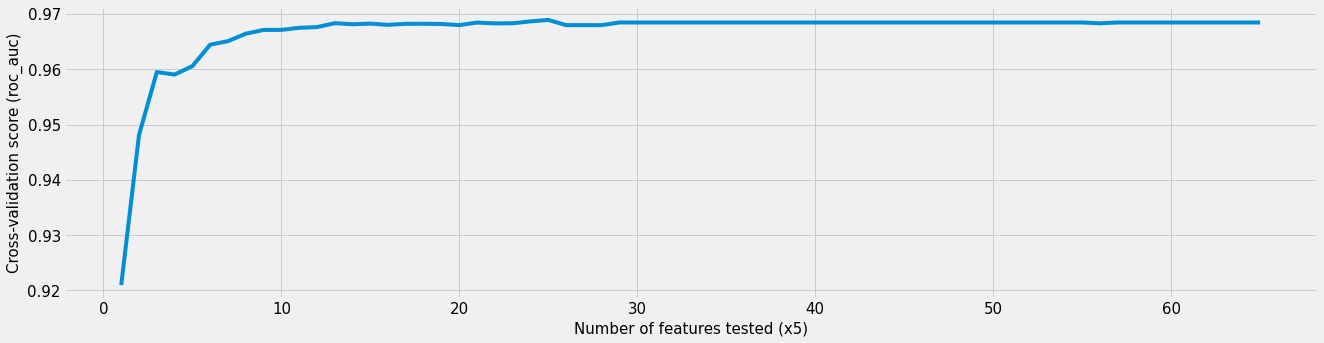

In [54]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
plt.show()

In [55]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307507, 117)

Il est nécessaire de sauvegarder le dataset X_data de manière à pouvoir le réutiliser facilement…

In [56]:
X_data.shape

(307507, 117)

In [57]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_data.zip', index=True, compression=compression_opts)

Wall time: 1min 26s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 117 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [58]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_sample.zip', index=True, compression=compression_opts)

Wall time: 9.34 s


In [59]:
%%time
X_data.sample(10000).to_csv('C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/X_sample.csv', index=True)

Wall time: 2.32 s


In [60]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [ ]:
y_train, y_test

### Apprentissage à l'aide de la fonction fit sur le jeu de données d'apprentissage

In [61]:
reg_LogisticRegression.fit(X_train_selected, y_train)
reg_CatBoostClassifier.fit(X_train_selected, y_train)
reg_LGBMClassifier.fit(X_train_selected, y_train)
reg_XGBClassifier.fit(X_train_selected, y_train)

Learning rate set to 0.102118
0:	learn: 0.5932843	total: 744ms	remaining: 12m 23s
1:	learn: 0.5116235	total: 939ms	remaining: 7m 48s
2:	learn: 0.4558717	total: 1.07s	remaining: 5m 57s
3:	learn: 0.4098437	total: 1.18s	remaining: 4m 54s
4:	learn: 0.3780685	total: 1.29s	remaining: 4m 17s
5:	learn: 0.3519695	total: 1.43s	remaining: 3m 56s
6:	learn: 0.3328546	total: 1.57s	remaining: 3m 42s
7:	learn: 0.3154099	total: 1.69s	remaining: 3m 29s
8:	learn: 0.3024113	total: 1.82s	remaining: 3m 20s
9:	learn: 0.2932465	total: 1.94s	remaining: 3m 11s
10:	learn: 0.2858020	total: 2.07s	remaining: 3m 5s
11:	learn: 0.2793199	total: 2.18s	remaining: 2m 59s
12:	learn: 0.2745595	total: 2.33s	remaining: 2m 56s
13:	learn: 0.2699908	total: 2.45s	remaining: 2m 52s
14:	learn: 0.2666150	total: 2.59s	remaining: 2m 50s
15:	learn: 0.2639647	total: 2.7s	remaining: 2m 46s
16:	learn: 0.2620680	total: 2.81s	remaining: 2m 42s
17:	learn: 0.2602924	total: 2.96s	remaining: 2m 41s
18:	learn: 0.2584902	total: 3.11s	remaining: 

160:	learn: 0.2347925	total: 22.4s	remaining: 1m 56s
161:	learn: 0.2347145	total: 22.6s	remaining: 1m 56s
162:	learn: 0.2346701	total: 22.7s	remaining: 1m 56s
163:	learn: 0.2346084	total: 22.8s	remaining: 1m 56s
164:	learn: 0.2345164	total: 23s	remaining: 1m 56s
165:	learn: 0.2344476	total: 23.1s	remaining: 1m 56s
166:	learn: 0.2343849	total: 23.2s	remaining: 1m 55s
167:	learn: 0.2343343	total: 23.3s	remaining: 1m 55s
168:	learn: 0.2342561	total: 23.5s	remaining: 1m 55s
169:	learn: 0.2341683	total: 23.6s	remaining: 1m 55s
170:	learn: 0.2341231	total: 23.7s	remaining: 1m 54s
171:	learn: 0.2340524	total: 23.8s	remaining: 1m 54s
172:	learn: 0.2340056	total: 23.9s	remaining: 1m 54s
173:	learn: 0.2339633	total: 24s	remaining: 1m 53s
174:	learn: 0.2338932	total: 24.1s	remaining: 1m 53s
175:	learn: 0.2338279	total: 24.2s	remaining: 1m 53s
176:	learn: 0.2337440	total: 24.3s	remaining: 1m 53s
177:	learn: 0.2336772	total: 24.5s	remaining: 1m 52s
178:	learn: 0.2336231	total: 24.6s	remaining: 1m 5

316:	learn: 0.2264971	total: 42.2s	remaining: 1m 30s
317:	learn: 0.2264594	total: 42.4s	remaining: 1m 30s
318:	learn: 0.2264206	total: 42.5s	remaining: 1m 30s
319:	learn: 0.2263749	total: 42.6s	remaining: 1m 30s
320:	learn: 0.2263153	total: 42.7s	remaining: 1m 30s
321:	learn: 0.2262785	total: 42.8s	remaining: 1m 30s
322:	learn: 0.2262505	total: 42.9s	remaining: 1m 29s
323:	learn: 0.2261896	total: 43.1s	remaining: 1m 29s
324:	learn: 0.2261430	total: 43.2s	remaining: 1m 29s
325:	learn: 0.2260877	total: 43.4s	remaining: 1m 29s
326:	learn: 0.2260217	total: 43.5s	remaining: 1m 29s
327:	learn: 0.2259717	total: 43.7s	remaining: 1m 29s
328:	learn: 0.2259142	total: 43.9s	remaining: 1m 29s
329:	learn: 0.2258616	total: 44s	remaining: 1m 29s
330:	learn: 0.2258077	total: 44.2s	remaining: 1m 29s
331:	learn: 0.2257656	total: 44.3s	remaining: 1m 29s
332:	learn: 0.2257362	total: 44.5s	remaining: 1m 29s
333:	learn: 0.2257038	total: 44.7s	remaining: 1m 29s
334:	learn: 0.2256401	total: 44.9s	remaining: 1m

472:	learn: 0.2194740	total: 1m 2s	remaining: 1m 9s
473:	learn: 0.2194315	total: 1m 2s	remaining: 1m 9s
474:	learn: 0.2194032	total: 1m 2s	remaining: 1m 9s
475:	learn: 0.2193635	total: 1m 2s	remaining: 1m 9s
476:	learn: 0.2193236	total: 1m 3s	remaining: 1m 9s
477:	learn: 0.2192823	total: 1m 3s	remaining: 1m 9s
478:	learn: 0.2192498	total: 1m 3s	remaining: 1m 8s
479:	learn: 0.2192018	total: 1m 3s	remaining: 1m 8s
480:	learn: 0.2191789	total: 1m 3s	remaining: 1m 8s
481:	learn: 0.2191361	total: 1m 3s	remaining: 1m 8s
482:	learn: 0.2190895	total: 1m 3s	remaining: 1m 8s
483:	learn: 0.2190539	total: 1m 3s	remaining: 1m 8s
484:	learn: 0.2190049	total: 1m 4s	remaining: 1m 8s
485:	learn: 0.2189647	total: 1m 4s	remaining: 1m 7s
486:	learn: 0.2189165	total: 1m 4s	remaining: 1m 7s
487:	learn: 0.2188769	total: 1m 4s	remaining: 1m 7s
488:	learn: 0.2188543	total: 1m 4s	remaining: 1m 7s
489:	learn: 0.2188099	total: 1m 4s	remaining: 1m 7s
490:	learn: 0.2187867	total: 1m 4s	remaining: 1m 7s
491:	learn: 

629:	learn: 0.2133858	total: 1m 21s	remaining: 47.6s
630:	learn: 0.2133509	total: 1m 21s	remaining: 47.5s
631:	learn: 0.2133143	total: 1m 21s	remaining: 47.3s
632:	learn: 0.2132896	total: 1m 21s	remaining: 47.2s
633:	learn: 0.2132484	total: 1m 21s	remaining: 47.1s
634:	learn: 0.2132149	total: 1m 21s	remaining: 46.9s
635:	learn: 0.2131592	total: 1m 21s	remaining: 46.8s
636:	learn: 0.2131294	total: 1m 21s	remaining: 46.7s
637:	learn: 0.2130759	total: 1m 21s	remaining: 46.5s
638:	learn: 0.2130415	total: 1m 22s	remaining: 46.4s
639:	learn: 0.2129986	total: 1m 22s	remaining: 46.3s
640:	learn: 0.2129461	total: 1m 22s	remaining: 46.1s
641:	learn: 0.2128943	total: 1m 22s	remaining: 46s
642:	learn: 0.2128701	total: 1m 22s	remaining: 45.9s
643:	learn: 0.2128340	total: 1m 22s	remaining: 45.7s
644:	learn: 0.2128054	total: 1m 22s	remaining: 45.6s
645:	learn: 0.2127664	total: 1m 22s	remaining: 45.5s
646:	learn: 0.2127243	total: 1m 23s	remaining: 45.3s
647:	learn: 0.2126964	total: 1m 23s	remaining: 4

786:	learn: 0.2076859	total: 1m 40s	remaining: 27.1s
787:	learn: 0.2076551	total: 1m 40s	remaining: 27s
788:	learn: 0.2076077	total: 1m 40s	remaining: 26.9s
789:	learn: 0.2075650	total: 1m 40s	remaining: 26.8s
790:	learn: 0.2075255	total: 1m 40s	remaining: 26.6s
791:	learn: 0.2074936	total: 1m 40s	remaining: 26.5s
792:	learn: 0.2074545	total: 1m 41s	remaining: 26.4s
793:	learn: 0.2074252	total: 1m 41s	remaining: 26.3s
794:	learn: 0.2073798	total: 1m 41s	remaining: 26.1s
795:	learn: 0.2073363	total: 1m 41s	remaining: 26s
796:	learn: 0.2073012	total: 1m 41s	remaining: 25.9s
797:	learn: 0.2072592	total: 1m 41s	remaining: 25.8s
798:	learn: 0.2072465	total: 1m 41s	remaining: 25.6s
799:	learn: 0.2072150	total: 1m 42s	remaining: 25.5s
800:	learn: 0.2071767	total: 1m 42s	remaining: 25.4s
801:	learn: 0.2071347	total: 1m 42s	remaining: 25.3s
802:	learn: 0.2070722	total: 1m 42s	remaining: 25.1s
803:	learn: 0.2070415	total: 1m 42s	remaining: 25s
804:	learn: 0.2070049	total: 1m 42s	remaining: 24.9s

942:	learn: 0.2022866	total: 1m 59s	remaining: 7.24s
943:	learn: 0.2022466	total: 1m 59s	remaining: 7.11s
944:	learn: 0.2022152	total: 1m 59s	remaining: 6.98s
945:	learn: 0.2021685	total: 2m	remaining: 6.85s
946:	learn: 0.2021262	total: 2m	remaining: 6.72s
947:	learn: 0.2020817	total: 2m	remaining: 6.6s
948:	learn: 0.2020614	total: 2m	remaining: 6.47s
949:	learn: 0.2020198	total: 2m	remaining: 6.34s
950:	learn: 0.2019959	total: 2m	remaining: 6.21s
951:	learn: 0.2019612	total: 2m	remaining: 6.09s
952:	learn: 0.2019325	total: 2m	remaining: 5.96s
953:	learn: 0.2019031	total: 2m 1s	remaining: 5.83s
954:	learn: 0.2018702	total: 2m 1s	remaining: 5.71s
955:	learn: 0.2018427	total: 2m 1s	remaining: 5.58s
956:	learn: 0.2018257	total: 2m 1s	remaining: 5.46s
957:	learn: 0.2017842	total: 2m 1s	remaining: 5.33s
958:	learn: 0.2017639	total: 2m 1s	remaining: 5.2s
959:	learn: 0.2017380	total: 2m 1s	remaining: 5.07s
960:	learn: 0.2016923	total: 2m 1s	remaining: 4.95s
961:	learn: 0.2016720	total: 2m 2s	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Prédictions et évaluation sur de la performance des différents algorithmes sur le jeu de données test

In [62]:
# Sauvegarde des performances correspondantes
import math

dict_modeles = {
    'LogisticRegression': reg_LogisticRegression,
    'CatBoostClassifier': reg_CatBoostClassifier,
    'LGBMClassifier': reg_LGBMClassifier,
    'XGBClassifier': reg_XGBClassifier
}

nom_modeles = ['LogisticRegression', 'CatBoostClassifier','LGBMClassifier', 'XGBClassifier']
liste_modeles = [dict_modeles['LogisticRegression'],
                 dict_modeles['CatBoostClassifier'],
                 dict_modeles['LGBMClassifier'],
                 dict_modeles['XGBClassifier']]

comparaison_performance1 = pd.DataFrame(index = nom_modeles, columns = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'])
for nom_modele, modele in zip(nom_modeles, liste_modeles):
    comparaison_performance1.loc[nom_modele, 'AUC'] = roc_auc_score(y_test, modele.predict(X_test_selected))
    comparaison_performance1.loc[nom_modele, 'Accuracy'] = accuracy_score(y_test, modele.predict(X_test_selected))
    comparaison_performance1.loc[nom_modele, 'Precision'] = precision_score(y_test, modele.predict(X_test_selected))
    comparaison_performance1.loc[nom_modele, 'Recall'] = recall_score(y_test, modele.predict(X_test_selected))
    comparaison_performance1.loc[nom_modele, 'F1'] = f1_score(y_test, modele.predict(X_test_selected))

In [63]:
comparaison_performance1.sort_values(by = 'AUC')

,AUC,Accuracy,Precision,Recall,F1
LogisticRegression,0.5,0.919331,0.0,0.0,0.0
LGBMClassifier,0.516069,0.920252,0.600473,0.034131,0.06459
CatBoostClassifier,0.521725,0.919721,0.527027,0.047165,0.086581
XGBClassifier,0.524897,0.919016,0.482881,0.054958,0.098685


### La fonction coût sera déterminée par l'analyse des erreurs de prédiction

**FP (False Positive)** : les cas où la prédiction est positive, mais où la valeur réelle est négative.

Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé.

**FN (False Negative)** : les cas où la prédiction est négative, mais où la valeur réelle est positive.

Perte réelle si le crédit client accepté se transforme en défaut de paiement.

**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs**.

L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut **maximiser deux critères Recall et Precision**.

L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β). Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.
* Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
* 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

On peut se fixer l'hypothèse d'un Beta = 3. Vérifions-le avec une étape de tests fonctionnels.

In [65]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("----------------------------")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

----------------------------
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
----------------------------
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
----------------------------
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
----------------------------
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
----------------------------
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
----------------------------
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

### 2-5 Hyperparameters tunning - Hyperopt et AUC score

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.


In [68]:
#!pip install hyperopt

In [92]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [93]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

In [94]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [95]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03, 0.005),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95, 0.1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20, 5)
    }

In [96]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [97]:
%%time
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, rstate=np.random.RandomState(1))

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'integers'

In [ ]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/LGBMClassifier.pkl", "wb"))

In [ ]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

In [ ]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    plt.show()

In [ ]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [ ]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

In [ ]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'}
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)

In [ ]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open("C:/Users/ESSE/Documents/Formation_Data_Science/Projet_07/LGBMClassifier.pkl", "wb"))

In [ ]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

In [ ]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [ ]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 